In [1]:
import ee
ee.Authenticate()            # abrirá una URL; copiá el código de vuelta en la consola
ee.Initialize()              # opcional: ee.Initialize(project='tu-proyecto-gcp')


In [2]:
import ee
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import unicodedata
from functools import reduce as _reduce

# ================= CONFIG =================
PROVINCES = ["Buenos Aires", "Cordoba", "Santa Fe", "Chaco", "Entre Rios", "La Pampa"]

# Rangos: histórico para promedio y año actual (END exclusivo)
RANGE_HIST = ("2017-01-01", "2024-12-31")
RANGE_CURR = ("2025-01-01", (date.today() + timedelta(days=1)).strftime("%Y-%m-%d"))

# Activar datasets
DO_IMERG = True    # precipitación IMERG 30-min -> diario
DO_ERA5  = True    # temp 2m y precip ERA5-Land diario
DO_LST   = True    # MODIS LST día/noche diario
DO_ET    = False   # MODIS ET 8 días (opcional)
DO_NDVI  = False   # MODIS NDVI 16 días (opcional)

# Escalas para promedios espaciales
SCALE_IMERG = 11000
SCALE_ERA5  = 11000
SCALE_LST   = 1000
SCALE_ET    = 500
SCALE_NDVI  = 250

# Salidas (CSV)
CSV_HIST = "gee_alertas_hist_2017_2024.csv"
CSV_CURR = "gee_alertas_2025.csv"
CSV_ALL  = "gee_alertas_multi_2017_2025.csv"

# ================= INIT =================
ee.Initialize()

# ================= HELPERS =================
def _norm(s: str) -> str:
    if s is None: return ""
    s = unicodedata.normalize('NFD', s)
    return ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn').lower().strip()

def provinces_fc(names):
    """FC GAUL(AR) con prop 'province' y geometría; match de nombres sin acentos/mayúsculas."""
    gaul = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq("ADM0_NAME", "Argentina"))
    feats = gaul.getInfo()["features"]
    gaul_map = {_norm(f["properties"]["ADM1_NAME"]): f["properties"]["ADM1_NAME"] for f in feats}
    resolved = []
    for n in names:
        k = _norm(n)
        if k in gaul_map: resolved.append(gaul_map[k])
        else: print(f"⚠️ No encontré '{n}' en GAUL.")
    fc = gaul.filter(ee.Filter.inList("ADM1_NAME", resolved))
    fc = fc.map(lambda f: ee.Feature(ee.Feature(f).geometry(), {"province": ee.Feature(f).get("ADM1_NAME")}))
    try:
        print("✅ Provincias GAUL:", ee.FeatureCollection(fc).aggregate_array('province').getInfo())
    except: pass
    return fc

def dates_list(start_str, end_str):
    start = ee.Date(start_str); end = ee.Date(end_str)
    n = end.difference(start, "day").toInt()
    return ee.List.sequence(0, n.subtract(1)).map(lambda k: start.advance(ee.Number(k), "day"))

def month_range(y0, m0, y1, m1):
    cur = datetime(y0, m0, 1); end = datetime(y1, m1, 1); out = []
    while cur <= end:
        nxty = cur.year + (cur.month // 12); nxtm = (cur.month % 12) + 1
        nxt = datetime(nxty, nxtm, 1)
        out.append((cur.strftime('%Y-%m-%d'), nxt.strftime('%Y-%m-%d')))
        cur = nxt
    return out

def fc_to_df(fc, cols_keep):
    feats = ee.FeatureCollection(fc).getInfo()["features"]
    rows = []
    for f in feats:
        p = f.get("properties", {}) or {}
        rows.append({c: p.get(c) for c in cols_keep})
    return pd.DataFrame(rows, columns=cols_keep) if rows else pd.DataFrame(columns=cols_keep)

def reduce_ic_over_provinces(ic, prov_fc, scale, band_map, dataset_name):
    """
    reduceRegions mean sobre provincias para CADA imagen; devuelve FC sin geometría,
    solo con: province, date, dataset y bandas renombradas.
    """
    in_bands  = list(band_map.keys())
    out_bands = list(band_map.values())
    keys_keep = ee.List(out_bands).cat(ee.List(['province', 'date', 'dataset']))

    def per_image(img):
        img = ee.Image(img).select(in_bands, out_bands)
        dstr = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")
        fc = img.reduceRegions(collection=prov_fc, reducer=ee.Reducer.mean(), scale=scale, tileScale=4) \
                .map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(ee.List(out_bands).cat(ee.List(['province']))))
                     .set({'date': dstr, 'dataset': dataset_name}))
        fc = fc.map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(keys_keep)))
        return fc

    return ee.FeatureCollection(ic.map(per_image).flatten())

# ================= DATASET BUILDERS (CHUNK MENSUAL) =================
PROV_FC = provinces_fc(PROVINCES)

def build_imerg_df_month(ms, me):
    ic_30m = ee.ImageCollection("NASA/GPM_L3/IMERG_V07").filterDate(ms, me).select("precipitation")
    days = dates_list(ms, me)
    def daily_image(d):
        d = ee.Date(d)
        day_ic = ic_30m.filterDate(d, d.advance(1, "day"))
        daily = ee.Image(ee.Algorithms.If(day_ic.size().gt(0), day_ic.sum().multiply(0.5), ee.Image.constant(0))) \
                  .rename("imerg_precip_mm").set("system:time_start", d.millis())
        return daily
    daily_ic = ee.ImageCollection(days.map(daily_image))
    fc = reduce_ic_over_provinces(daily_ic, PROV_FC, SCALE_IMERG, {"imerg_precip_mm":"imerg_precip_mm"}, "IMERG")
    return fc_to_df(fc, ["province","date","imerg_precip_mm"])

def build_era5_df_month(ms, me):
    ic = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate(ms, me) \
         .select(["temperature_2m", "total_precipitation_sum"])
    def conv(img):
        t2mC = ee.Image(img).select("temperature_2m").subtract(273.15).rename("era5_t2m_C")
        prmm = ee.Image(img).select("total_precipitation_sum").multiply(1000.0).rename("era5_precip_mm")
        return t2mC.addBands(prmm).copyProperties(img, ["system:time_start"])
    ic = ic.map(conv)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ERA5,
                                  {"era5_t2m_C":"era5_t2m_C","era5_precip_mm":"era5_precip_mm"}, "ERA5")
    return fc_to_df(fc, ["province","date","era5_t2m_C","era5_precip_mm"])

def build_lst_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD11A1").filterDate(ms, me) \
         .select(["LST_Day_1km","LST_Night_1km"])
    def toC(img):
        dayC   = ee.Image(img).select("LST_Day_1km").multiply(0.02).subtract(273.15).rename("lst_day_C")
        nightC = ee.Image(img).select("LST_Night_1km").multiply(0.02).subtract(273.15).rename("lst_night_C")
        return dayC.addBands(nightC).copyProperties(img, ["system:time_start"])
    ic = ic.map(toC)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_LST,
                                  {"lst_day_C":"lst_day_C","lst_night_C":"lst_night_C"}, "MODIS_LST")
    return fc_to_df(fc, ["province","date","lst_day_C","lst_night_C"])

def build_et_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD16A2").filterDate(ms, me).select(["ET"]) \
         .map(lambda img: ee.Image(img).multiply(0.1).rename("modis_et_mm_8d")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ET, {"modis_et_mm_8d":"modis_et_mm_8d"}, "MODIS_ET")
    return fc_to_df(fc, ["province","date","modis_et_mm_8d"])

def build_ndvi_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD13Q1").filterDate(ms, me).select(["NDVI"]) \
         .map(lambda img: ee.Image(img).multiply(0.0001).rename("modis_ndvi")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_NDVI, {"modis_ndvi":"modis_ndvi"}, "MODIS_NDVI")
    return fc_to_df(fc, ["province","date","modis_ndvi"])

def fetch_range_chunked(start_str, end_str):
    """Descarga rango en chunks mensuales por dataset y hace outer-merge por ['province','date']."""
    y0, m0 = int(start_str[:4]), int(start_str[5:7])
    y1, m1 = int(end_str[:4]), int(end_str[5:7])
    months = month_range(y0, m0, y1, m1)

    dfs = []
    if DO_IMERG:
        parts = []
        for ms, me in months:
            print(f"IMERG {ms} → {me}")
            parts.append(build_imerg_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","imerg_precip_mm"]))

    if DO_ERA5:
        parts = []
        for ms, me in months:
            print(f"ERA5 {ms} → {me}")
            parts.append(build_era5_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","era5_t2m_C","era5_precip_mm"]))

    if DO_LST:
        parts = []
        for ms, me in months:
            print(f"LST {ms} → {me}")
            parts.append(build_lst_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","lst_day_C","lst_night_C"]))

    if DO_ET:
        parts = []
        for ms, me in months:
            print(f"ET {ms} → {me}")
            parts.append(build_et_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_et_mm_8d"]))

    if DO_NDVI:
        parts = []
        for ms, me in months:
            print(f"NDVI {ms} → {me}")
            parts.append(build_ndvi_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_ndvi"]))

    if not dfs:
        return pd.DataFrame(columns=["province","date"])

    df = _reduce(lambda l, r: pd.merge(l, r, on=["province","date"], how="outer"), dfs)
    df = df.sort_values(["province","date"]).reset_index(drop=True)

    # numéricos + precip preferida
    for c in ["imerg_precip_mm","era5_precip_mm","era5_t2m_C","lst_day_C","lst_night_C","modis_et_mm_8d","modis_ndvi"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    if {"imerg_precip_mm","era5_precip_mm"}.issubset(df.columns):
        df["precip_mm_pref"] = df["imerg_precip_mm"].fillna(df["era5_precip_mm"])
    elif "era5_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["era5_precip_mm"]
    elif "imerg_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["imerg_precip_mm"]

    return df

# ================= RUN: HISTÓRICO + 2025 (chunk mensual) =================
print("=== Descargando HISTÓRICO ===")
df_hist = fetch_range_chunked(*RANGE_HIST)
print("=== Descargando 2025 ===")
df_2025 = fetch_range_chunked(*RANGE_CURR)

# Guardar CSVs (opcional)
if not df_hist.empty: df_hist.to_csv(CSV_HIST, index=False)
if not df_2025.empty: df_2025.to_csv(CSV_CURR, index=False)

# Unir todo
df_all_multi = pd.concat([df_hist, df_2025], ignore_index=True)
df_all_multi = df_all_multi.drop_duplicates(["province","date"]).sort_values(["province","date"]).reset_index(drop=True)
df_all_multi.to_csv(CSV_ALL, index=False)
print("✅ Guardado:", CSV_ALL, "| Filas:", len(df_all_multi))

# ================= CLIMATOLOGÍA + ANOMALÍAS (ejemplo con precip_mm_pref) =================
df = df_all_multi.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["mmdd"] = df["date"].dt.strftime("%m-%d")
var = "precip_mm_pref"

# Climatología 2017–2024
mask_hist = (df["date"] >= pd.to_datetime(RANGE_HIST[0])) & (df["date"] <= pd.to_datetime(RANGE_HIST[1]))
d_hist = df.loc[mask_hist & df[var].notna()].copy()
d_hist = d_hist[d_hist["mmdd"] != "02-29"]
clim = (d_hist.groupby(["province","mmdd"])[var]
          .agg(mean="mean", std="std", count="count")
          .reset_index())

# Anomalías 2025 vs histórico
d_2025 = df[(df["year"] == 2025) & df[var].notna()].copy()
d_2025 = d_2025[d_2025["mmdd"] != "02-29"]
anom = d_2025.merge(clim, on=["province","mmdd"], how="left", suffixes=("", "_clim"))
anom["anom"] = anom[var] - anom["mean"]
anom["anom_pct"] = np.where(anom["mean"].abs() > 1e-9, 100.0 * anom["anom"] / anom["mean"], np.nan)
anom["zscore"] = (anom["anom"] / anom["std"]).replace([np.inf, -np.inf], np.nan)

print("✅ Climatología filas:", len(clim), "| Anomalías 2025 filas:", len(anom))
print(anom[["province","date",var,"mean","anom","anom_pct","zscore"]].head())


✅ Provincias GAUL: ['Buenos Aires', 'Chaco', 'Cordoba', 'Entre Rios', 'La Pampa', 'Santa Fe']
=== Descargando HISTÓRICO ===
IMERG 2017-01-01 → 2017-02-01
IMERG 2017-02-01 → 2017-03-01
IMERG 2017-03-01 → 2017-04-01
IMERG 2017-04-01 → 2017-05-01
IMERG 2017-05-01 → 2017-06-01
IMERG 2017-06-01 → 2017-07-01
IMERG 2017-07-01 → 2017-08-01
IMERG 2017-08-01 → 2017-09-01
IMERG 2017-09-01 → 2017-10-01
IMERG 2017-10-01 → 2017-11-01
IMERG 2017-11-01 → 2017-12-01
IMERG 2017-12-01 → 2018-01-01
IMERG 2018-01-01 → 2018-02-01
IMERG 2018-02-01 → 2018-03-01
IMERG 2018-03-01 → 2018-04-01
IMERG 2018-04-01 → 2018-05-01
IMERG 2018-05-01 → 2018-06-01
IMERG 2018-06-01 → 2018-07-01
IMERG 2018-07-01 → 2018-08-01
IMERG 2018-08-01 → 2018-09-01
IMERG 2018-09-01 → 2018-10-01
IMERG 2018-10-01 → 2018-11-01
IMERG 2018-11-01 → 2018-12-01
IMERG 2018-12-01 → 2019-01-01
IMERG 2019-01-01 → 2019-02-01
IMERG 2019-02-01 → 2019-03-01
IMERG 2019-03-01 → 2019-04-01
IMERG 2019-04-01 → 2019-05-01
IMERG 2019-05-01 → 2019-06-01
IMERG 

💾 Guardado: plots\precip7_buenos_aires.png


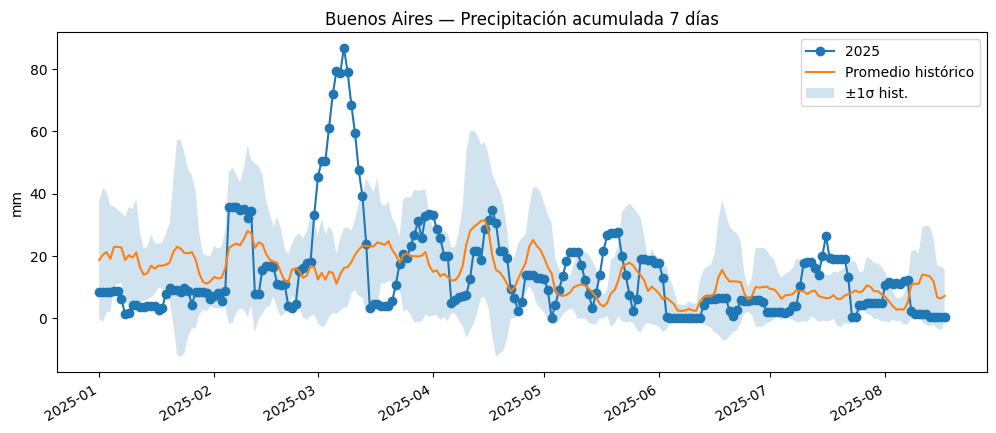

💾 Guardado: plots\precip7_chaco.png


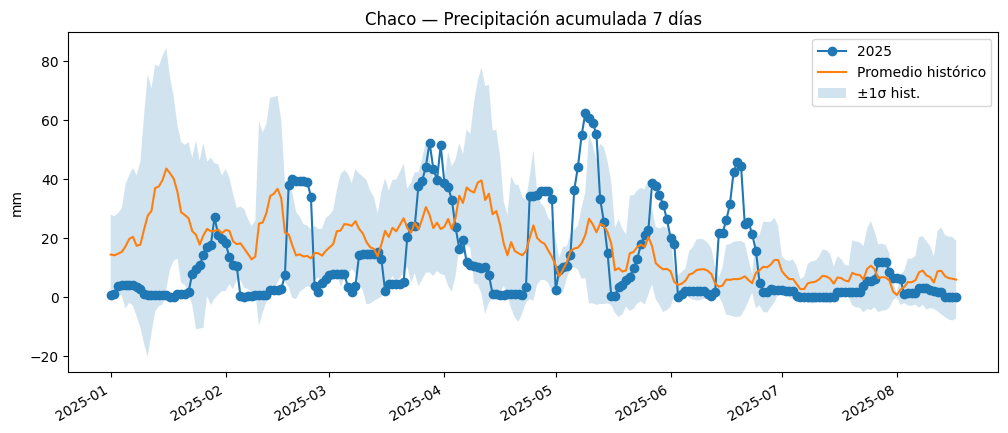

💾 Guardado: plots\precip7_cordoba.png


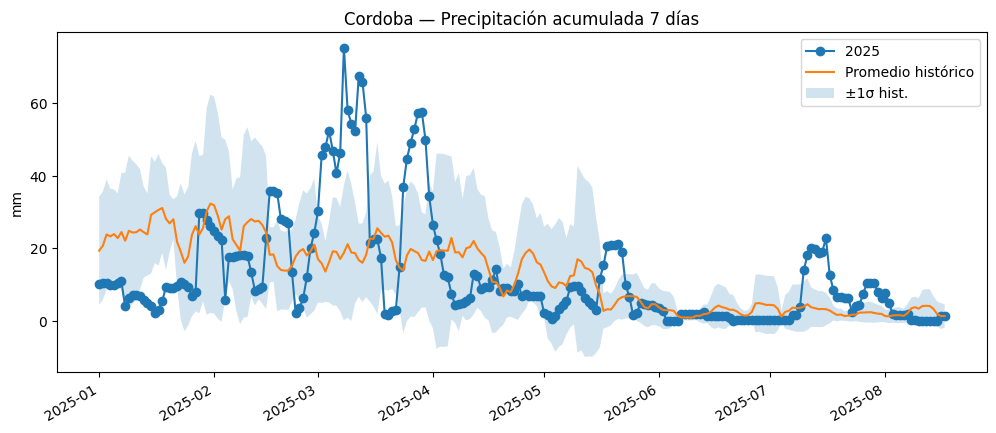

💾 Guardado: plots\precip7_entre_rios.png


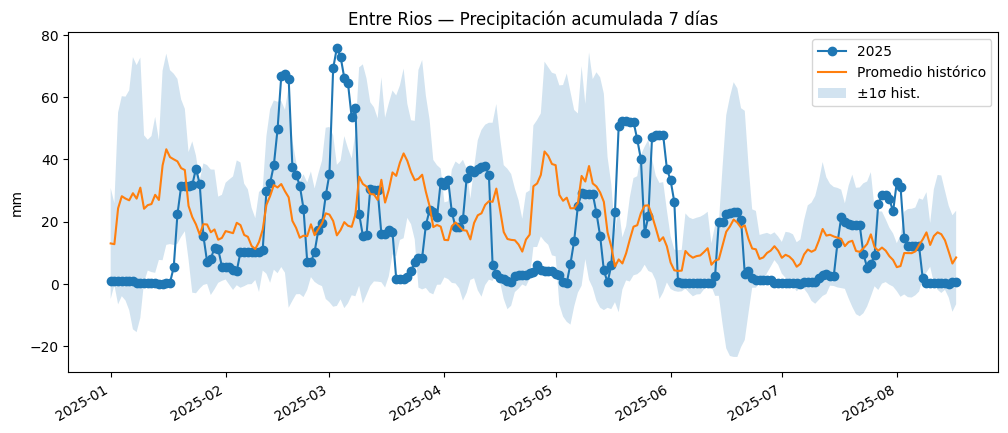

💾 Guardado: plots\precip7_la_pampa.png


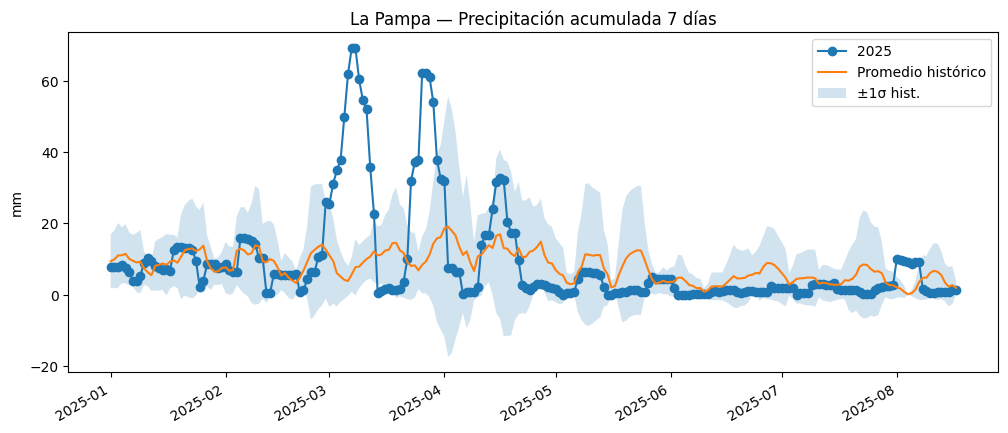

💾 Guardado: plots\precip7_santa_fe.png


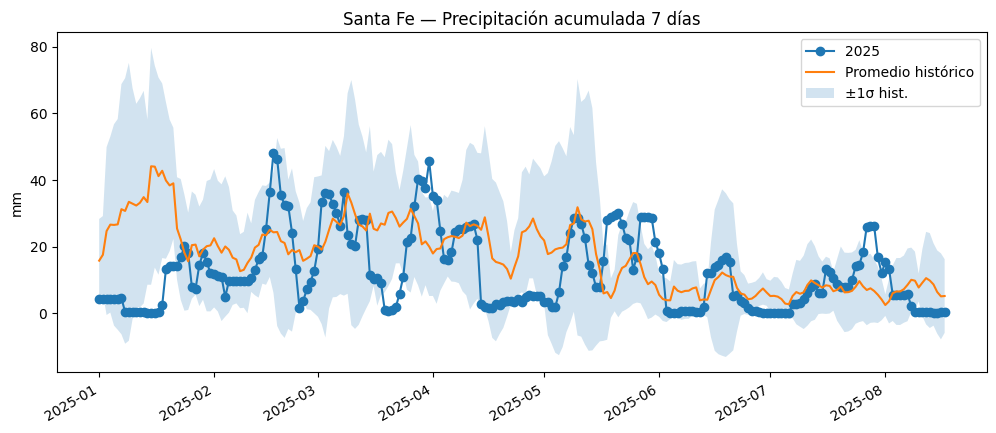

💾 Guardado: plots\t2m7_buenos_aires.png


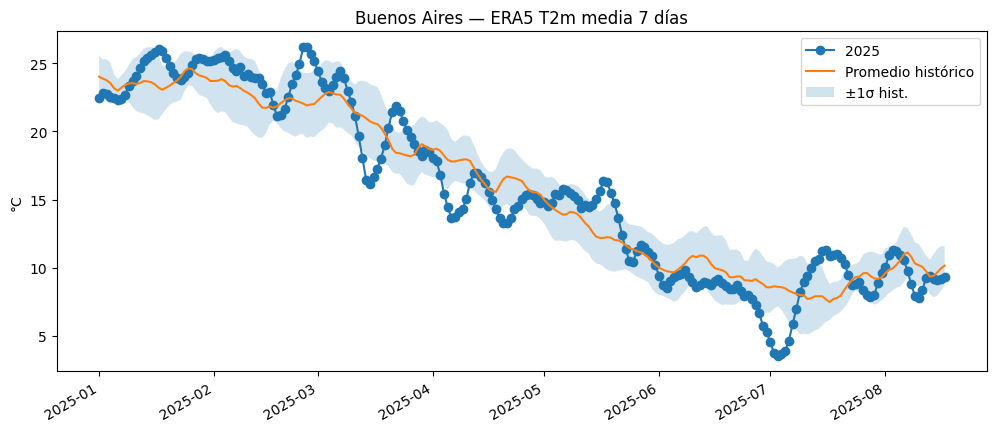

💾 Guardado: plots\t2m7_chaco.png


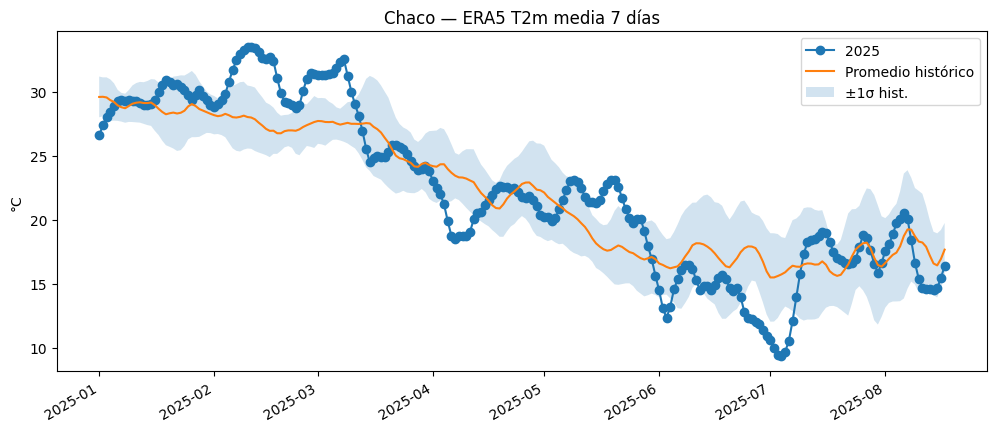

💾 Guardado: plots\t2m7_cordoba.png


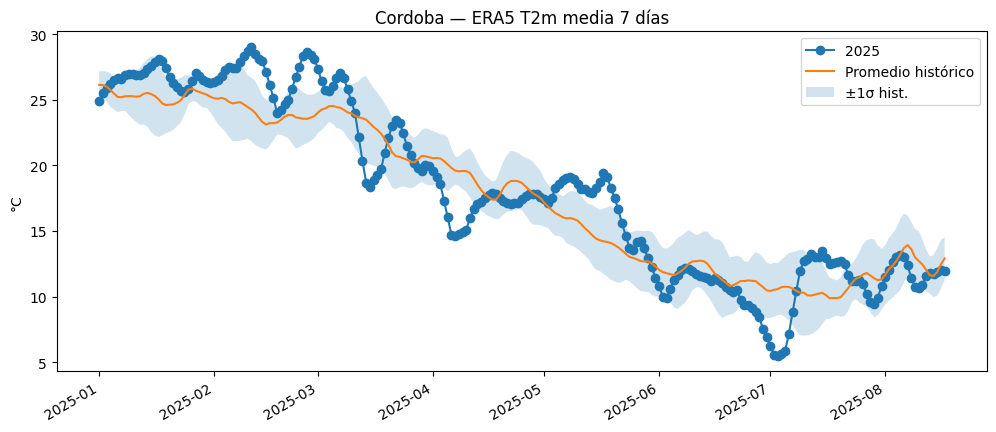

💾 Guardado: plots\t2m7_entre_rios.png


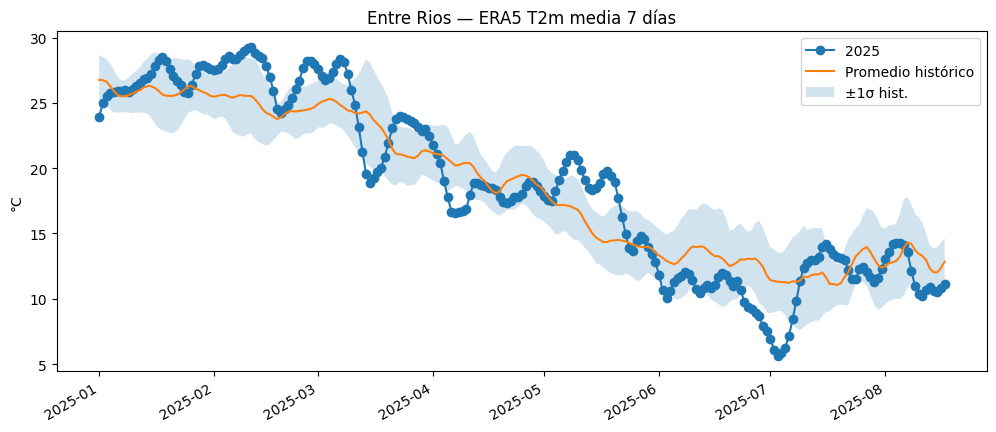

💾 Guardado: plots\t2m7_la_pampa.png


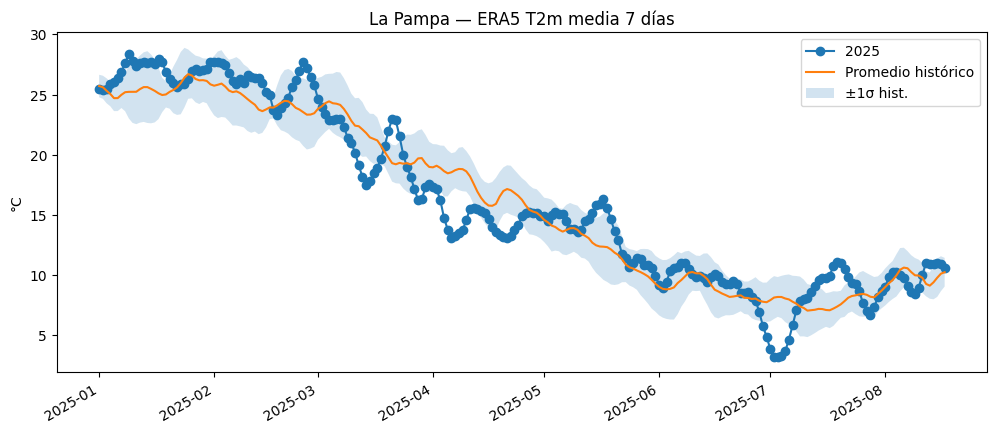

💾 Guardado: plots\t2m7_santa_fe.png


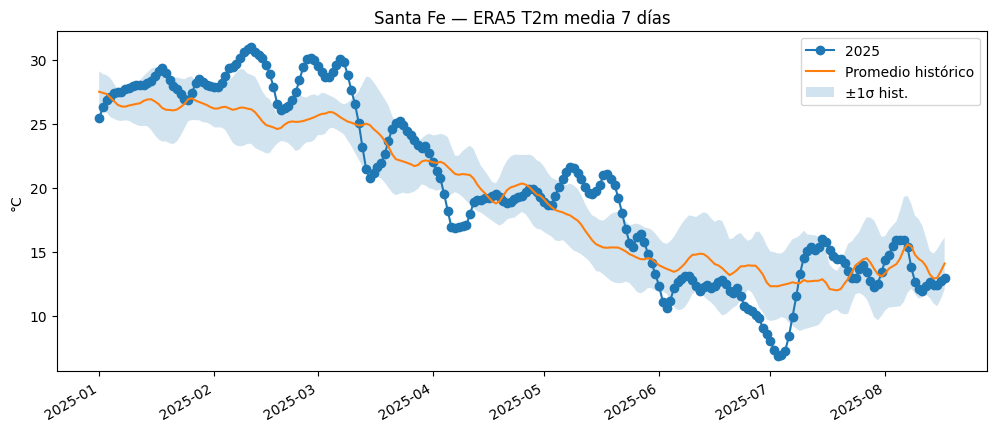

💾 Guardado: plots\lstd7_buenos_aires.png


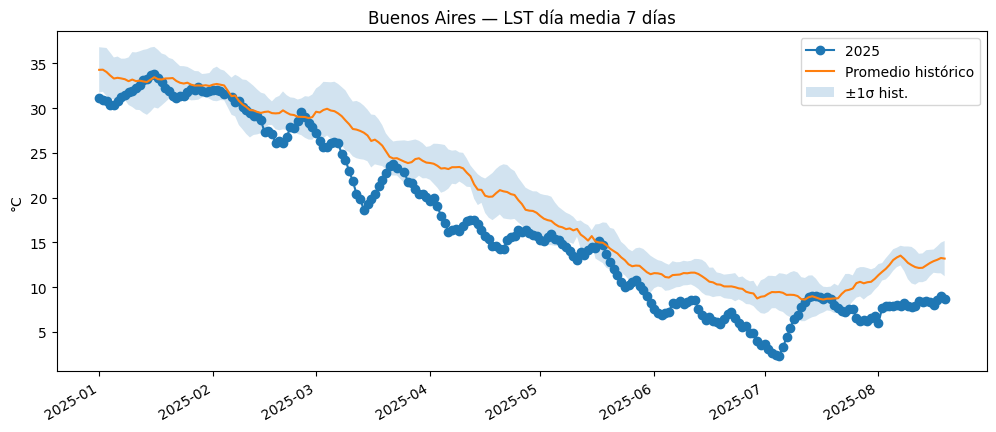

💾 Guardado: plots\lstd7_chaco.png


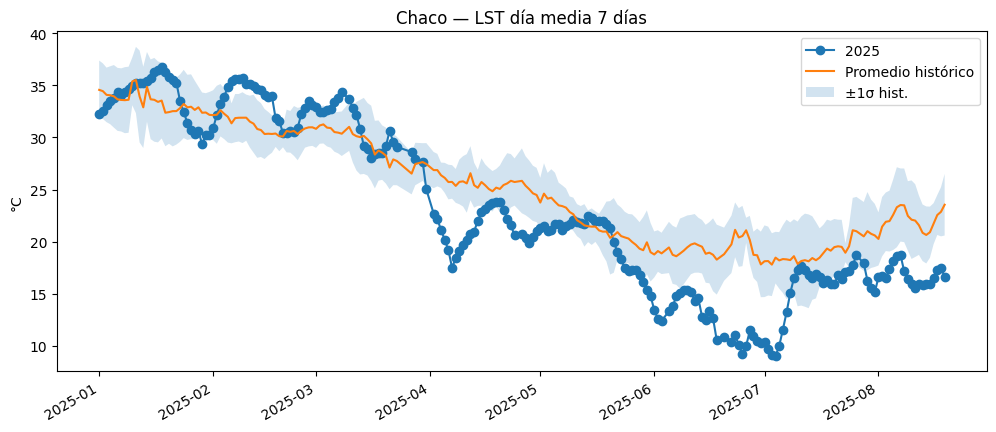

💾 Guardado: plots\lstd7_cordoba.png


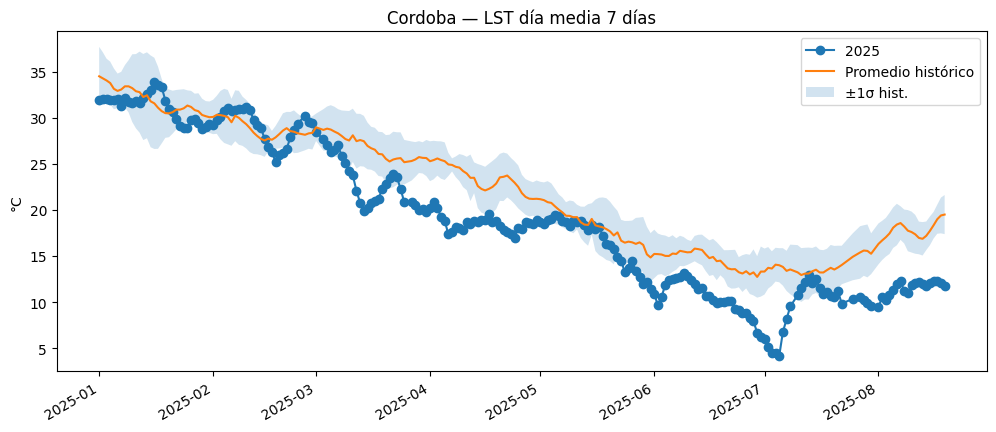

💾 Guardado: plots\lstd7_entre_rios.png


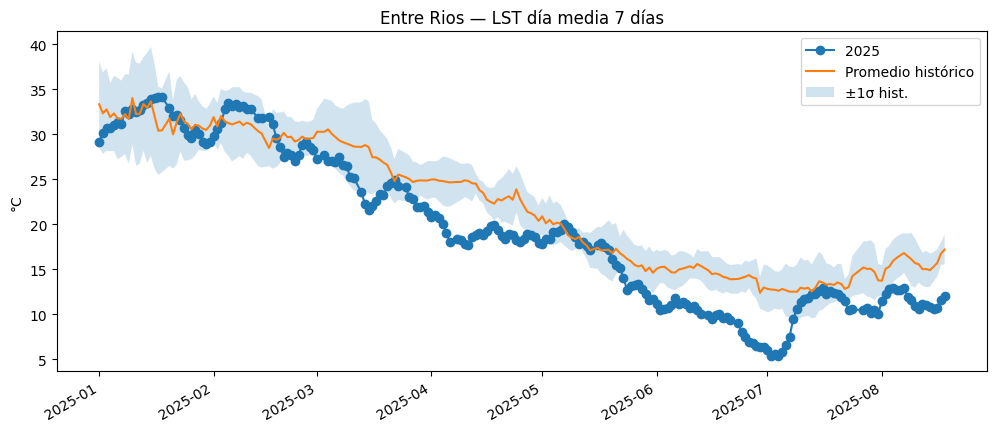

💾 Guardado: plots\lstd7_la_pampa.png


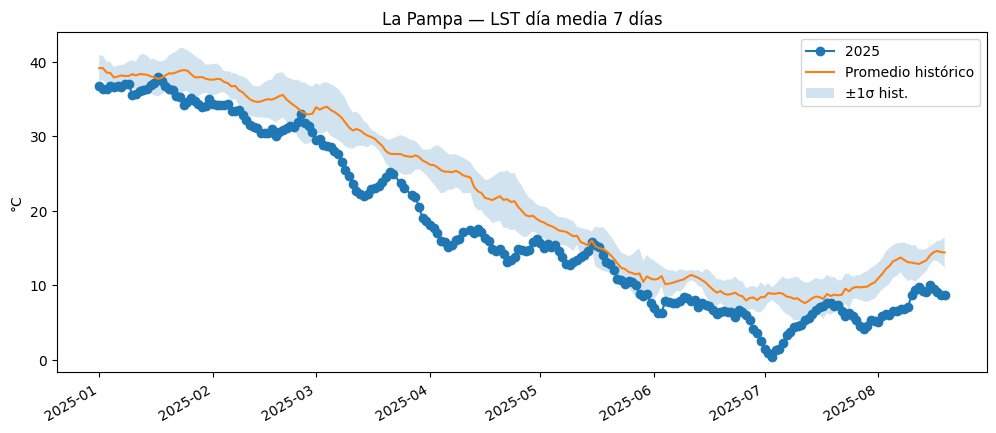

💾 Guardado: plots\lstd7_santa_fe.png


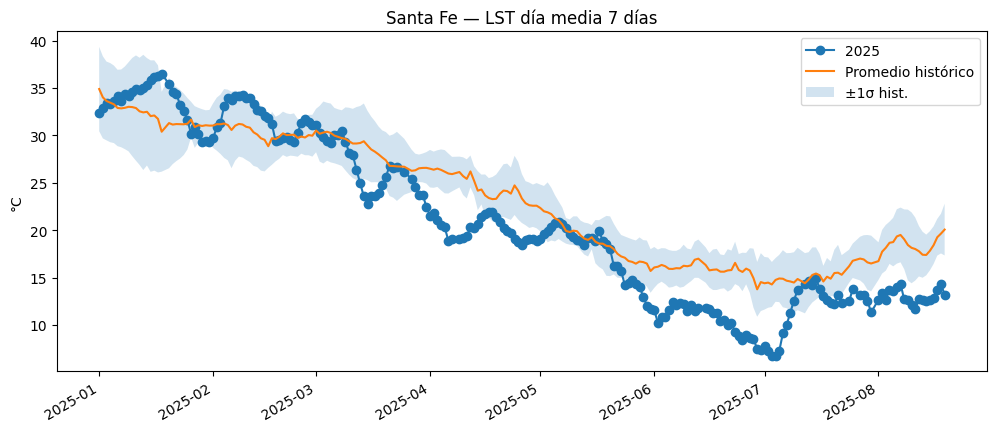

💾 Guardado: plots\lstn7_buenos_aires.png


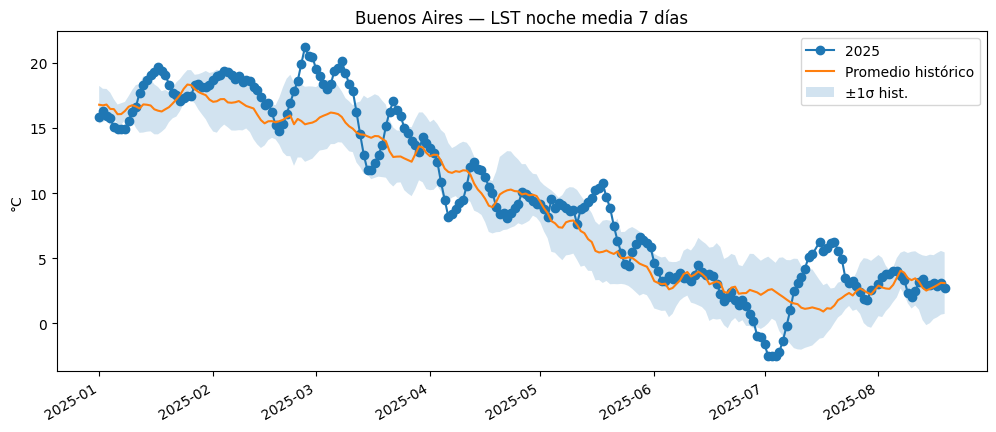

💾 Guardado: plots\lstn7_chaco.png


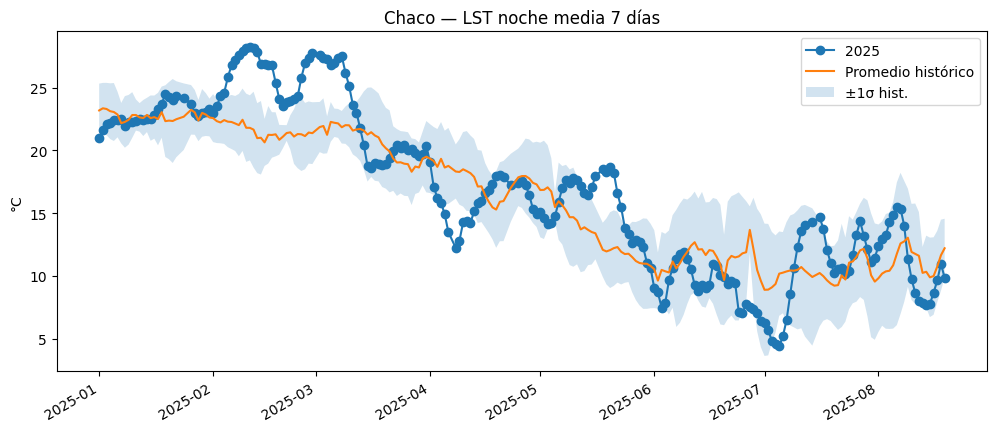

💾 Guardado: plots\lstn7_cordoba.png


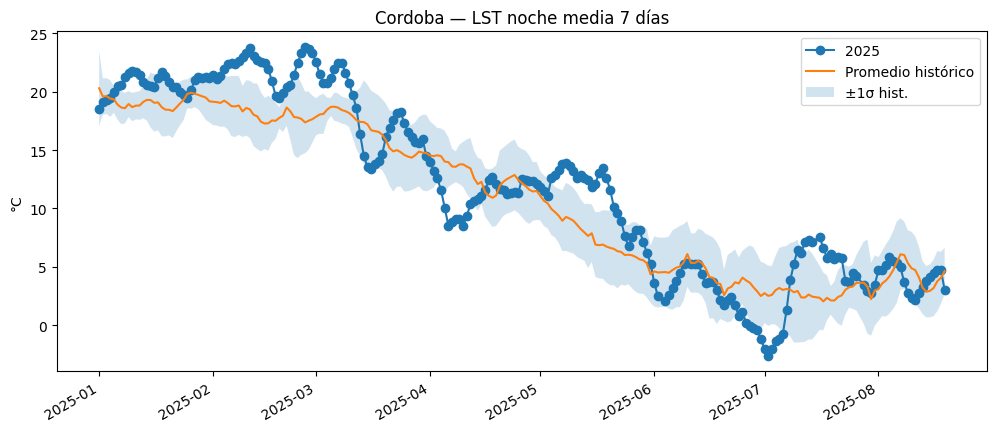

💾 Guardado: plots\lstn7_entre_rios.png


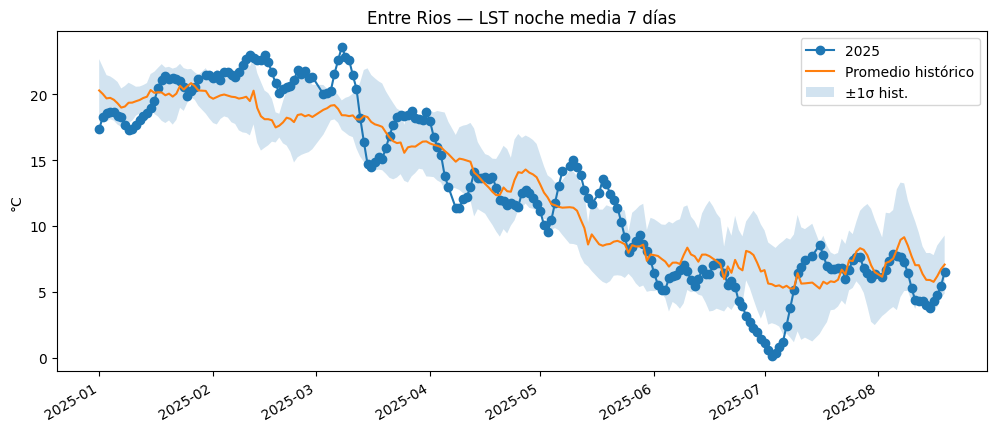

💾 Guardado: plots\lstn7_la_pampa.png


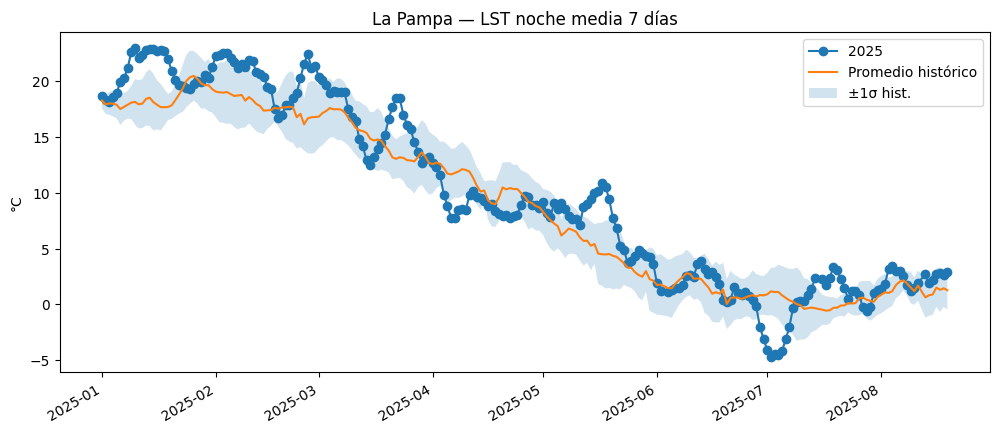

💾 Guardado: plots\lstn7_santa_fe.png


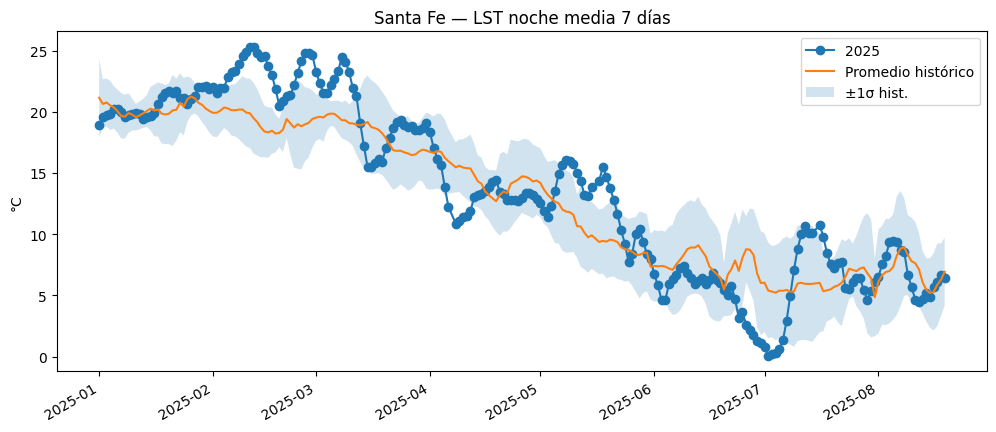

In [3]:
# ====== Comparación provincia vs promedio histórico (todas las variables) ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Cargar datos (usa df_all_multi si ya lo tenés en memoria; si no, lee CSV)
try:
    df = df_all_multi.copy()
except NameError:
    df = pd.read_csv("gee_alertas_multi_2017_2025.csv", parse_dates=["date"])

# --- Configuración de periodos
HIST_START = "2017-01-01"
HIST_END   = "2024-12-31"
TARGET_YEAR = 2025

# --- Variables a graficar: modo de suavizado y ventana
VARS = [
    {"var":"precip_mm_pref", "label":"Precipitación acumulada 7 días", "unit":"mm", "mode":"sum",  "window":7, "slug":"precip7"},
    {"var":"era5_t2m_C",     "label":"ERA5 T2m media 7 días",          "unit":"°C", "mode":"mean", "window":7, "slug":"t2m7"},
    {"var":"lst_day_C",      "label":"LST día media 7 días",           "unit":"°C", "mode":"mean", "window":7, "slug":"lstd7"},
    {"var":"lst_night_C",    "label":"LST noche media 7 días",         "unit":"°C", "mode":"mean", "window":7, "slug":"lstn7"},
    # Si más adelante activás ET/NDVI, podés sumar:
    # {"var":"modis_et_mm_8d","label":"ET (mm/8d) (mantener sin suavizado)", "unit":"mm/8d","mode":"raw","window":1,"slug":"et8d"},
    # {"var":"modis_ndvi",    "label":"NDVI (sin suavizado)",               "unit":"",     "mode":"raw","window":1,"slug":"ndvi"},
]

# --- Limpieza base
df = df.copy()
df["date"] = pd.to_datetime(df["date"])
for c in ["imerg_precip_mm","era5_precip_mm","precip_mm_pref","era5_t2m_C","lst_day_C","lst_night_C",
          "modis_et_mm_8d","modis_ndvi"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.sort_values(["province","date"])

# --- Helpers
def compute_rolled(df, var, mode="mean", window=7):
    """Devuelve serie suavizada por provincia con 'value', y columnas year/mmdd."""
    d = df[["province","date",var]].dropna().copy()
    d = d.sort_values(["province","date"])
    if mode == "sum":
        d["value"] = d.groupby("province")[var].transform(lambda s: s.rolling(window, min_periods=1).sum())
    elif mode == "mean":
        d["value"] = d.groupby("province")[var].transform(lambda s: s.rolling(window, min_periods=1).mean())
    else:  # raw
        d["value"] = d[var]
    d["year"] = d["date"].dt.year
    d["mmdd"] = d["date"].dt.strftime("%m-%d")
    d = d[d["mmdd"] != "02-29"]
    return d[["province","date","year","mmdd","value"]]

def climatology_from_rolled(d, hist_start=HIST_START, hist_end=HIST_END):
    """Promedio y std por provincia y día-mes, usando la serie ya suavizada."""
    mask = (d["date"] >= pd.to_datetime(hist_start)) & (d["date"] <= pd.to_datetime(hist_end))
    dh = d.loc[mask].copy()
    clim = (dh.groupby(["province","mmdd"])["value"]
              .agg(mean="mean", std="std", count="count")
              .reset_index())
    return clim

def anomalies_vs_clim(d, clim, target_year=TARGET_YEAR):
    """Une el año objetivo con la climatología y calcula anomalías."""
    cur = d[d["year"] == target_year].copy()
    m = cur.merge(clim, on=["province","mmdd"], how="left")
    m["anom"] = m["value"] - m["mean"]
    m["anom_pct"] = np.where(m["mean"].abs() > 1e-9, 100.0 * m["anom"] / m["mean"], np.nan)
    m["zscore"] = (m["anom"] / m["std"]).replace([np.inf, -np.inf], np.nan)
    return m.sort_values(["province","date"])

def plot_var_vs_clim(m, province, title, ylabel, save_dir="plots", filename=None):
    """Grafica 2025 vs promedio histórico con banda ±1σ y guarda PNG."""
    d = m[m["province"] == province].sort_values("date")
    if d.empty:
        print(f"⚠️ Sin datos para {province} en {title}.")
        return
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(d["date"], d["value"], marker="o", label="2025")
    ax.plot(d["date"], d["mean"], label="Promedio histórico")
    if d["std"].notna().any():
        ax.fill_between(d["date"], d["mean"] - d["std"], d["mean"] + d["std"], alpha=0.2, label="±1σ hist.")
    ax.set_title(f"{province} — {title}")
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.autofmt_xdate()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fname = filename or (title.replace(" ", "_").lower() + f"_{province}.png")
        out = os.path.join(save_dir, fname.replace(" ", "_").lower())
        plt.savefig(out, bbox_inches="tight", dpi=140)
        print("💾 Guardado:", out)
    plt.show()

# --- Driver: recorre variables y provincias
provinces = sorted(df["province"].dropna().unique())
for cfg in VARS:
    var = cfg["var"]
    if var not in df.columns:
        print(f"ℹ️ Omito {var}: no está en el DataFrame.")
        continue
    drolled = compute_rolled(df, var, mode=cfg["mode"], window=cfg["window"])
    clim = climatology_from_rolled(drolled, HIST_START, HIST_END)
    m = anomalies_vs_clim(drolled, clim, TARGET_YEAR)
    for prov in provinces:
        plot_var_vs_clim(
            m, prov,
            title=cfg["label"],
            ylabel=cfg["unit"],
            save_dir="plots",
            filename=f"{cfg['slug']}_{prov}.png"
        )


# Codigo optimizado

In [6]:
import ee
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import unicodedata
from functools import reduce as _reduce
from pathlib import Path

# ================= CONFIG =================
PROVINCES = ["Buenos Aires", "Cordoba", "Santa Fe", "Chaco", "Entre Rios", "La Pampa"]

# Rangos: histórico para promedio y año actual (END exclusivo)
RANGE_HIST = ("2017-01-01", "2024-12-31")
RANGE_CURR = ("2025-01-01", (date.today() + timedelta(days=1)).strftime("%Y-%m-%d"))

# Activar datasets
DO_IMERG = True    # precipitación IMERG 30-min -> diario
DO_ERA5  = True    # temp 2m y precip ERA5-Land diario
DO_LST   = True    # MODIS LST día/noche diario
DO_ET    = False   # MODIS ET 8 días (opcional)
DO_NDVI  = False   # MODIS NDVI 16 días (opcional)

# Escalas para promedios espaciales
SCALE_IMERG = 11000
SCALE_ERA5  = 11000
SCALE_LST   = 1000
SCALE_ET    = 500
SCALE_NDVI  = 250

# Salidas (CSV)
CSV_HIST = "gee_alertas_hist_2017_2024.csv"
CSV_CURR = "gee_alertas_2025.csv"
CSV_ALL  = "gee_alertas_multi_2017_2025.csv"

# Modo de actualización
INCREMENTAL_MODE = True   # True: solo nuevos datos; False: volver a descargar todo
BACKFILL_DAYS    = 7      # acolchado para revisiones/retrasos de publicación

# ================= INIT =================
ee.Initialize()

# ================= HELPERS =================
def _norm(s: str) -> str:
    if s is None: return ""
    s = unicodedata.normalize('NFD', s)
    return ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn').lower().strip()

def provinces_fc(names):
    """FC GAUL(AR) con prop 'province' y geometría; match de nombres sin acentos/mayúsculas."""
    gaul = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq("ADM0_NAME", "Argentina"))
    feats = gaul.getInfo()["features"]
    gaul_map = {_norm(f["properties"]["ADM1_NAME"]): f["properties"]["ADM1_NAME"] for f in feats}
    resolved = []
    for n in names:
        k = _norm(n)
        if k in gaul_map: resolved.append(gaul_map[k])
        else: print(f"⚠️ No encontré '{n}' en GAUL.")
    fc = gaul.filter(ee.Filter.inList("ADM1_NAME", resolved))
    fc = fc.map(lambda f: ee.Feature(ee.Feature(f).geometry(), {"province": ee.Feature(f).get("ADM1_NAME")}))
    try:
        print("✅ Provincias GAUL:", ee.FeatureCollection(fc).aggregate_array('province').getInfo())
    except: pass
    return fc

def dates_list(start_str, end_str):
    start = ee.Date(start_str); end = ee.Date(end_str)
    n = end.difference(start, "day").toInt()
    return ee.List.sequence(0, n.subtract(1)).map(lambda k: start.advance(ee.Number(k), "day"))

def month_range(y0, m0, y1, m1):
    cur = datetime(y0, m0, 1); end = datetime(y1, m1, 1); out = []
    while cur <= end:
        nxty = cur.year + (cur.month // 12); nxtm = (cur.month % 12) + 1
        nxt = datetime(nxty, nxtm, 1)
        out.append((cur.strftime('%Y-%m-%d'), nxt.strftime('%Y-%m-%d')))
        cur = nxt
    return out

def fc_to_df(fc, cols_keep):
    feats = ee.FeatureCollection(fc).getInfo()["features"]
    rows = []
    for f in feats:
        p = f.get("properties", {}) or {}
        rows.append({c: p.get(c) for c in cols_keep})
    return pd.DataFrame(rows, columns=cols_keep) if rows else pd.DataFrame(columns=cols_keep)

def reduce_ic_over_provinces(ic, prov_fc, scale, band_map, dataset_name):
    """
    reduceRegions mean sobre provincias para CADA imagen; devuelve FC sin geometría,
    solo con: province, date, dataset y bandas renombradas.
    """
    in_bands  = list(band_map.keys())
    out_bands = list(band_map.values())
    keys_keep = ee.List(out_bands).cat(ee.List(['province', 'date', 'dataset']))

    def per_image(img):
        img = ee.Image(img).select(in_bands, out_bands)
        dstr = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")
        fc = img.reduceRegions(collection=prov_fc, reducer=ee.Reducer.mean(), scale=scale, tileScale=4) \
                .map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(ee.List(out_bands).cat(ee.List(['province']))))
                     .set({'date': dstr, 'dataset': dataset_name}))
        fc = fc.map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(keys_keep)))
        return fc

    return ee.FeatureCollection(ic.map(per_image).flatten())

# ================= DATASET BUILDERS (CHUNK MENSUAL) =================
PROV_FC = provinces_fc(PROVINCES)

def build_imerg_df_month(ms, me):
    ic_30m = ee.ImageCollection("NASA/GPM_L3/IMERG_V07").filterDate(ms, me).select("precipitation")
    days = dates_list(ms, me)
    def daily_image(d):
        d = ee.Date(d)
        day_ic = ic_30m.filterDate(d, d.advance(1, "day"))
        daily = ee.Image(ee.Algorithms.If(day_ic.size().gt(0), day_ic.sum().multiply(0.5), ee.Image.constant(0))) \
                  .rename("imerg_precip_mm").set("system:time_start", d.millis())
        return daily
    daily_ic = ee.ImageCollection(days.map(daily_image))
    fc = reduce_ic_over_provinces(daily_ic, PROV_FC, SCALE_IMERG, {"imerg_precip_mm":"imerg_precip_mm"}, "IMERG")
    return fc_to_df(fc, ["province","date","imerg_precip_mm"])

def build_era5_df_month(ms, me):
    ic = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate(ms, me) \
         .select(["temperature_2m", "total_precipitation_sum"])
    def conv(img):
        t2mC = ee.Image(img).select("temperature_2m").subtract(273.15).rename("era5_t2m_C")
        prmm = ee.Image(img).select("total_precipitation_sum").multiply(1000.0).rename("era5_precip_mm")
        return t2mC.addBands(prmm).copyProperties(img, ["system:time_start"])
    ic = ic.map(conv)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ERA5,
                                  {"era5_t2m_C":"era5_t2m_C","era5_precip_mm":"era5_precip_mm"}, "ERA5")
    return fc_to_df(fc, ["province","date","era5_t2m_C","era5_precip_mm"])

def build_lst_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD11A1").filterDate(ms, me) \
         .select(["LST_Day_1km","LST_Night_1km"])
    def toC(img):
        dayC   = ee.Image(img).select("LST_Day_1km").multiply(0.02).subtract(273.15).rename("lst_day_C")
        nightC = ee.Image(img).select("LST_Night_1km").multiply(0.02).subtract(273.15).rename("lst_night_C")
        return dayC.addBands(nightC).copyProperties(img, ["system:time_start"])
    ic = ic.map(toC)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_LST,
                                  {"lst_day_C":"lst_day_C","lst_night_C":"lst_night_C"}, "MODIS_LST")
    return fc_to_df(fc, ["province","date","lst_day_C","lst_night_C"])

def build_et_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD16A2").filterDate(ms, me).select(["ET"]) \
         .map(lambda img: ee.Image(img).multiply(0.1).rename("modis_et_mm_8d")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ET, {"modis_et_mm_8d":"modis_et_mm_8d"}, "MODIS_ET")
    return fc_to_df(fc, ["province","date","modis_et_mm_8d"])

def build_ndvi_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD13Q1").filterDate(ms, me).select(["NDVI"]) \
         .map(lambda img: ee.Image(img).multiply(0.0001).rename("modis_ndvi")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_NDVI, {"modis_ndvi":"modis_ndvi"}, "MODIS_NDVI")
    return fc_to_df(fc, ["province","date","modis_ndvi"])

def fetch_range_chunked(start_str, end_str):
    """Descarga rango en chunks mensuales por dataset y hace outer-merge por ['province','date'].""" 
    y0, m0 = int(start_str[:4]), int(start_str[5:7])
    y1, m1 = int(end_str[:4]), int(end_str[5:7])
    months = month_range(y0, m0, y1, m1)

    dfs = []
    if DO_IMERG:
        parts = []
        for ms, me in months:
            print(f"IMERG {ms} → {me}")
            parts.append(build_imerg_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","imerg_precip_mm"]))

    if DO_ERA5:
        parts = []
        for ms, me in months:
            print(f"ERA5 {ms} → {me}")
            parts.append(build_era5_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","era5_t2m_C","era5_precip_mm"]))

    if DO_LST:
        parts = []
        for ms, me in months:
            print(f"LST {ms} → {me}")
            parts.append(build_lst_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","lst_day_C","lst_night_C"]))

    if DO_ET:
        parts = []
        for ms, me in months:
            print(f"ET {ms} → {me}")
            parts.append(build_et_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_et_mm_8d"]))

    if DO_NDVI:
        parts = []
        for ms, me in months:
            print(f"NDVI {ms} → {me}")
            parts.append(build_ndvi_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_ndvi"]))

    if not dfs:
        return pd.DataFrame(columns=["province","date"])

    df = _reduce(lambda l, r: pd.merge(l, r, on=["province","date"], how="outer"), dfs)
    df = df.sort_values(["province","date"]).reset_index(drop=True)

    # numéricos + precip preferida
    for c in ["imerg_precip_mm","era5_precip_mm","era5_t2m_C","lst_day_C","lst_night_C","modis_et_mm_8d","modis_ndvi"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    if {"imerg_precip_mm","era5_precip_mm"}.issubset(df.columns):
        df["precip_mm_pref"] = df["imerg_precip_mm"].fillna(df["era5_precip_mm"])
    elif "era5_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["era5_precip_mm"]
    elif "imerg_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["imerg_precip_mm"]

    return df

# ================= MODO INCREMENTAL =================
def incremental_update(csv_all_path=CSV_ALL, backfill_days=BACKFILL_DAYS):
    today_end = (date.today() + timedelta(days=1)).strftime("%Y-%m-%d")  # end exclusivo

    if Path(csv_all_path).exists() and INCREMENTAL_MODE:
        # 1) Cargar consolidado existente
        df_old = pd.read_csv(csv_all_path)  # sin parse_dates: lo manejamos nosotros
        if df_old.empty:
            last_dt = None
        else:
            s = pd.to_datetime(df_old["date"], errors="coerce")
            last_dt = s.max()
            df_old["date"] = s.dt.strftime("%Y-%m-%d")


        if last_dt is None:
            # Primer fetch si estaba vacío
            print("ℹ️ CSV consolidado vacío. Descargando histórico + 2025…")
            df_hist = fetch_range_chunked(*RANGE_HIST)
            df_curr = fetch_range_chunked(RANGE_CURR[0], today_end)
            df_new = pd.concat([df_hist, df_curr], ignore_index=True)
        else:
            # 2) Rango incremental: última fecha - backfill → hoy_end
            inc_start = (last_dt - pd.Timedelta(days=backfill_days)).strftime("%Y-%m-%d")
            print(f"🔄 Modo incremental: {inc_start} → {today_end} (backfill {backfill_days} días)")
            df_new = fetch_range_chunked(inc_start, today_end)

        # 3) Unir y deduplicar (preferimos los registros nuevos)
        df_all_multi = pd.concat([df_old, df_new], ignore_index=True)
        df_all_multi = (df_all_multi
                        .drop_duplicates(["province","date"], keep="last")
                        .sort_values(["province","date"])
                        .reset_index(drop=True))
        df_all_multi.to_csv(csv_all_path, index=False)
        print("✅ Actualizado:", csv_all_path, "| Filas:", len(df_all_multi))
        return df_all_multi

    else:
        # Primer corrido o modo full
        if INCREMENTAL_MODE:
            print("📥 Primer corrido (no existe CSV). Descargando histórico + 2025…")
        else:
            print("♻️ FULL REBUILD: re-descargando histórico + 2025…")
        df_hist = fetch_range_chunked(*RANGE_HIST)
        df_curr = fetch_range_chunked(RANGE_CURR[0], today_end)
        df_all_multi = pd.concat([df_hist, df_curr], ignore_index=True)
        df_all_multi = (df_all_multi
                        .drop_duplicates(["province","date"], keep="last")
                        .sort_values(["province","date"])
                        .reset_index(drop=True))
        df_all_multi.to_csv(csv_all_path, index=False)
        print("✅ Guardado inicial:", csv_all_path, "| Filas:", len(df_all_multi))
        return df_all_multi

# === Ejecutar actualización (incremental o full) ===
df_all_multi = incremental_update()

# ================= CLIMATOLOGÍA + ANOMALÍAS (ejemplo con precip_mm_pref) =================
df = df_all_multi.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["mmdd"] = df["date"].dt.strftime("%m-%d")
var = "precip_mm_pref"

# Climatología 2017–2024
mask_hist = (df["date"] >= pd.to_datetime(RANGE_HIST[0])) & (df["date"] <= pd.to_datetime(RANGE_HIST[1]))
d_hist = df.loc[mask_hist & df[var].notna()].copy()
d_hist = d_hist[d_hist["mmdd"] != "02-29"]
clim = (d_hist.groupby(["province","mmdd"])[var]
          .agg(mean="mean", std="std", count="count")
          .reset_index())

# Anomalías 2025 vs histórico
d_2025 = df[(df["year"] == 2025) & df[var].notna()].copy()
d_2025 = d_2025[d_2025["mmdd"] != "02-29"]
anom = d_2025.merge(clim, on=["province","mmdd"], how="left", suffixes=("", "_clim"))
anom["anom"] = anom[var] - anom["mean"]
anom["anom_pct"] = np.where(anom["mean"].abs() > 1e-9, 100.0 * anom["anom"] / anom["mean"], np.nan)
anom["zscore"] = (anom["anom"] / anom["std"]).replace([np.inf, -np.inf], np.nan)

print("✅ Climatología filas:", len(clim), "| Anomalías 2025 filas:", len(anom))
print(anom[["province","date",var,"mean","anom","anom_pct","zscore"]].head())


✅ Provincias GAUL: ['Buenos Aires', 'Chaco', 'Cordoba', 'Entre Rios', 'La Pampa', 'Santa Fe']
🔄 Modo incremental: 2025-08-24 → 2025-08-25 (backfill 7 días)
IMERG 2025-08-01 → 2025-09-01
ERA5 2025-08-01 → 2025-09-01
LST 2025-08-01 → 2025-09-01
✅ Actualizado: gee_alertas_multi_2017_2025.csv | Filas: 18990
✅ Climatología filas: 2190 | Anomalías 2025 filas: 1374
       province       date  precip_mm_pref      mean      anom   anom_pct  \
0  Buenos Aires 2025-01-01        4.934924  5.111599 -0.176675  -3.456350   
1  Buenos Aires 2025-01-02        0.321476  1.862046 -1.540570 -82.735344   
2  Buenos Aires 2025-01-03        0.039218  2.012844 -1.973627 -98.051619   
3  Buenos Aires 2025-01-04        0.020396  0.930555 -0.910159 -97.808205   
4  Buenos Aires 2025-01-05        0.576114  5.876726 -5.300612 -90.196686   

     zscore  
0 -0.027542  
1 -0.405219  
2 -0.468690  
3 -0.629229  
4 -0.655092  


✅ Provincias GAUL: ['Buenos Aires', 'Chaco', 'Cordoba', 'Entre Rios', 'La Pampa', 'Santa Fe']
🔄 Modo incremental: 2025-08-17 → 2025-08-25 (backfill 7 días)
IMERG 2025-08-01 → 2025-09-01
ERA5 2025-08-01 → 2025-09-01
LST 2025-08-01 → 2025-09-01
SMAP 2025-08-01 → 2025-09-01
✅ Actualizado: gee_alertas_multi_2017_2025.csv | Filas: 18990
🗺️ Suelos (textura) ya existe: gee_suelos_textura.csv
💾 Guardado: plots\precip7_buenos_aires.png


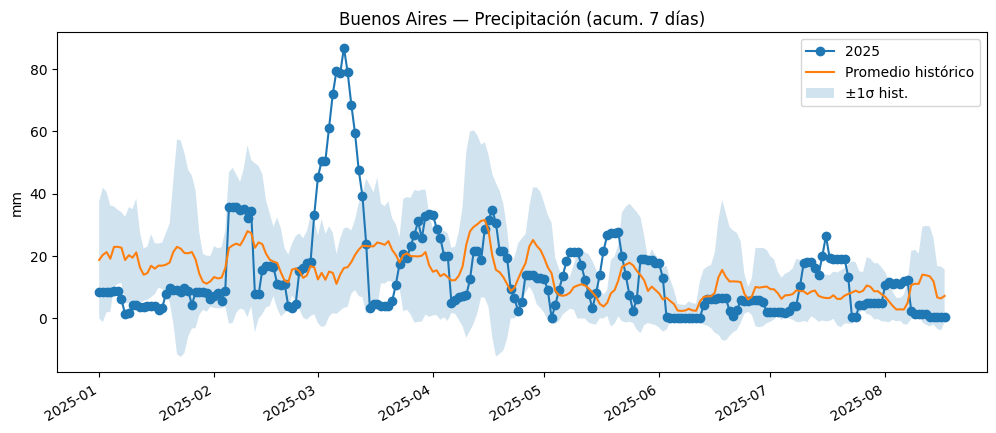

💾 Guardado: plots\precip7_chaco.png


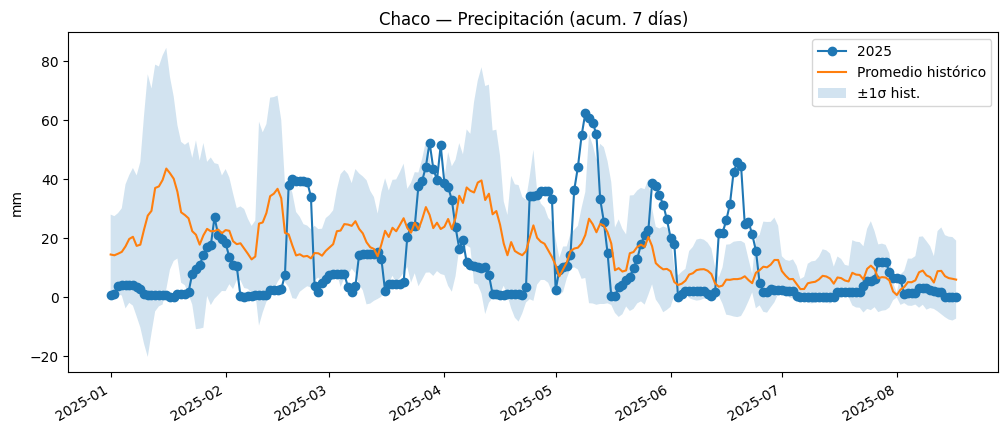

💾 Guardado: plots\precip7_cordoba.png


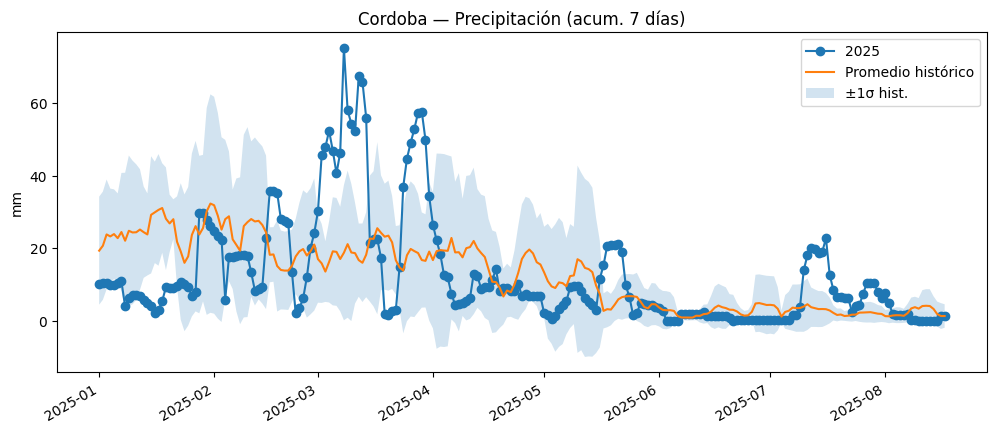

💾 Guardado: plots\precip7_entre_rios.png


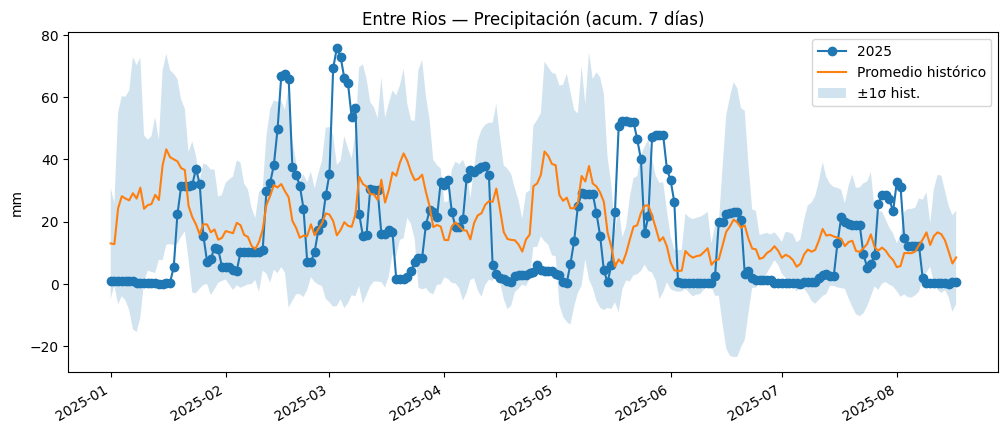

💾 Guardado: plots\precip7_la_pampa.png


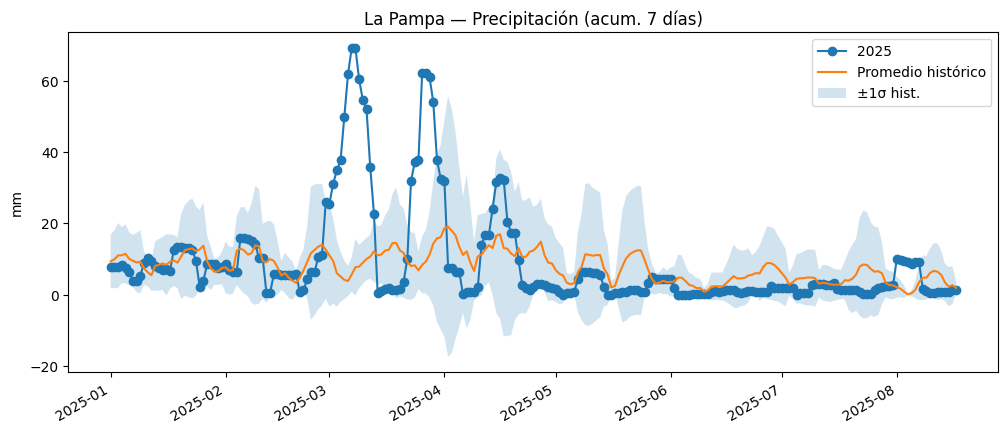

💾 Guardado: plots\precip7_santa_fe.png


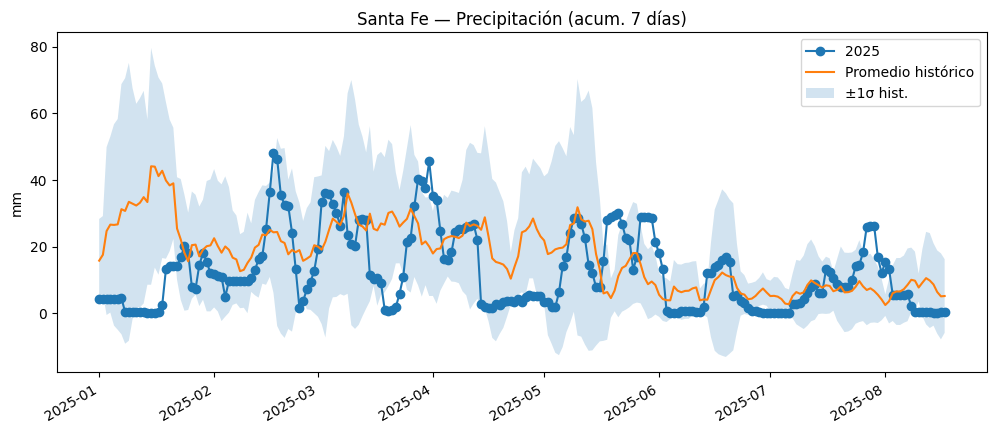

💾 Guardado: plots\t2m7_buenos_aires.png


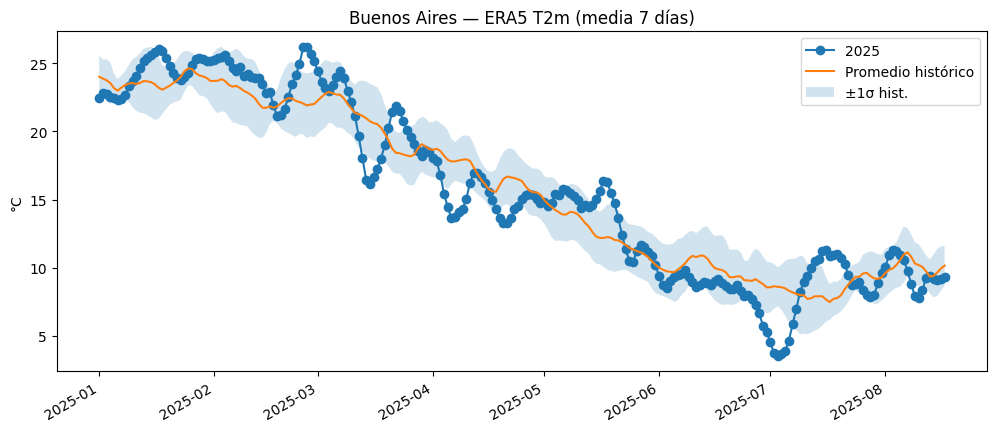

💾 Guardado: plots\t2m7_chaco.png


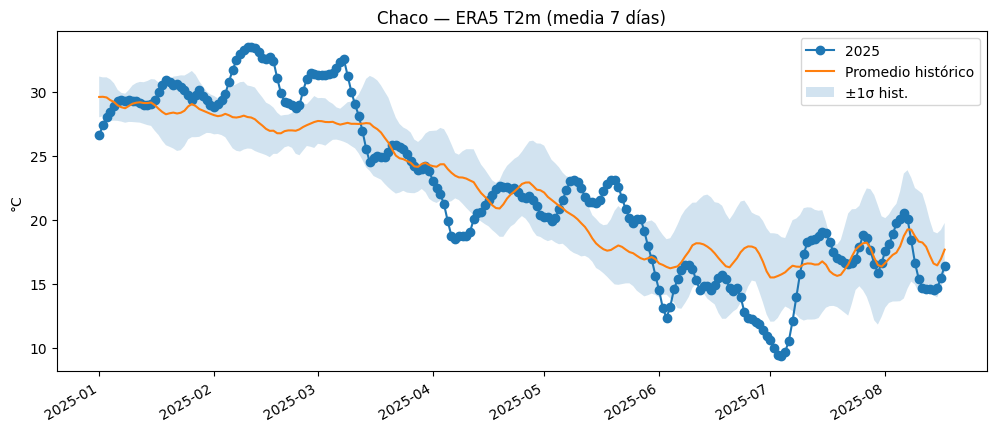

💾 Guardado: plots\t2m7_cordoba.png


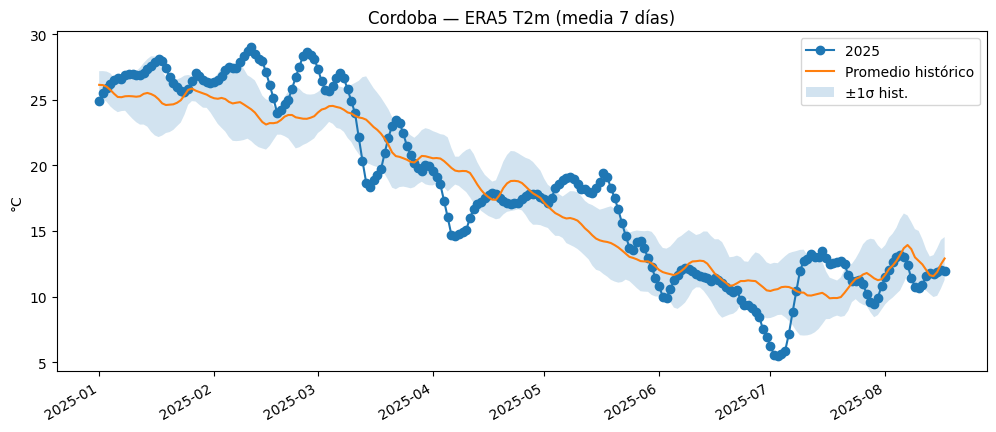

💾 Guardado: plots\t2m7_entre_rios.png


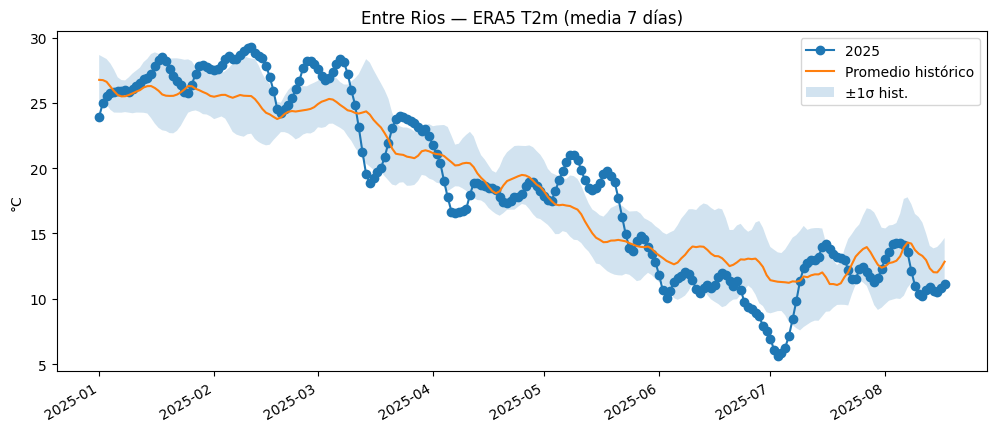

💾 Guardado: plots\t2m7_la_pampa.png


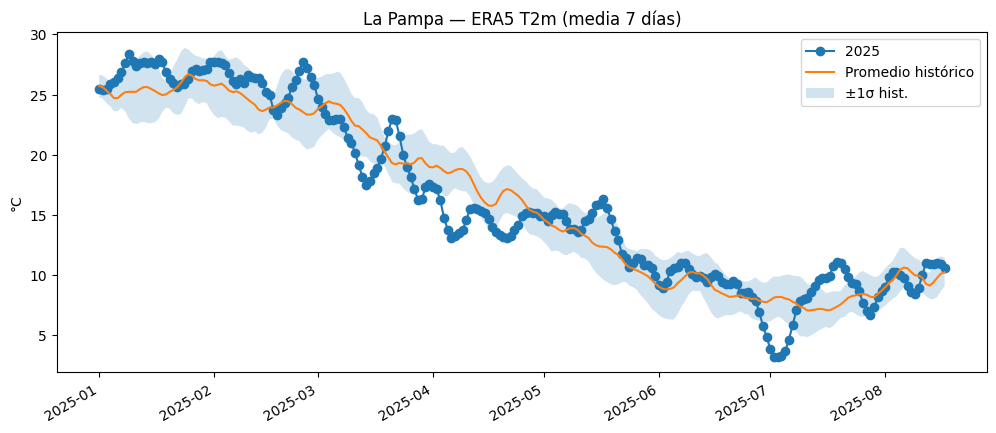

💾 Guardado: plots\t2m7_santa_fe.png


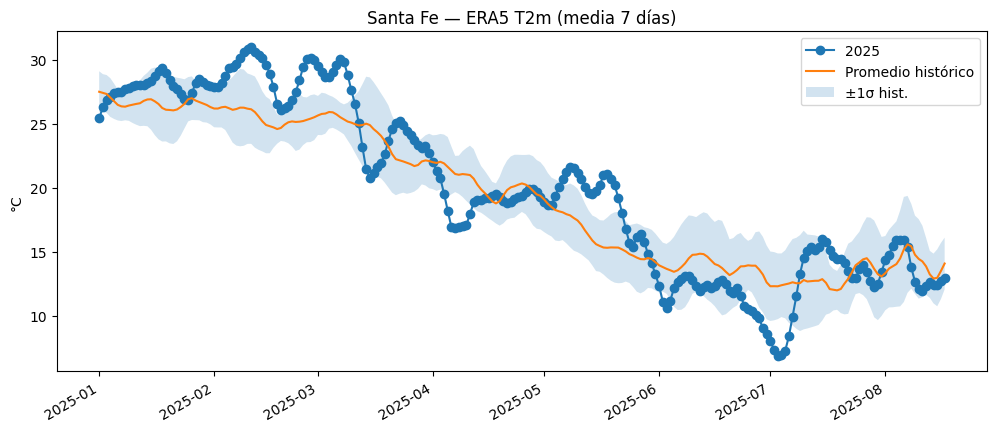

💾 Guardado: plots\lstd7_buenos_aires.png


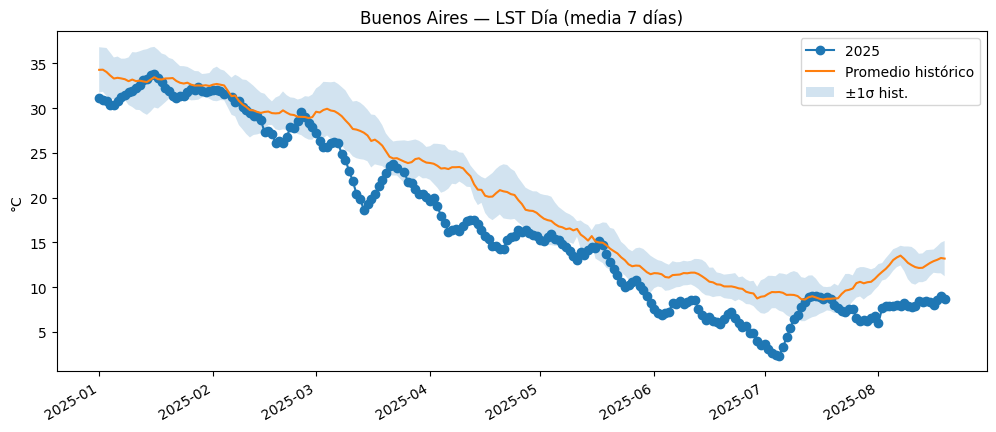

💾 Guardado: plots\lstd7_chaco.png


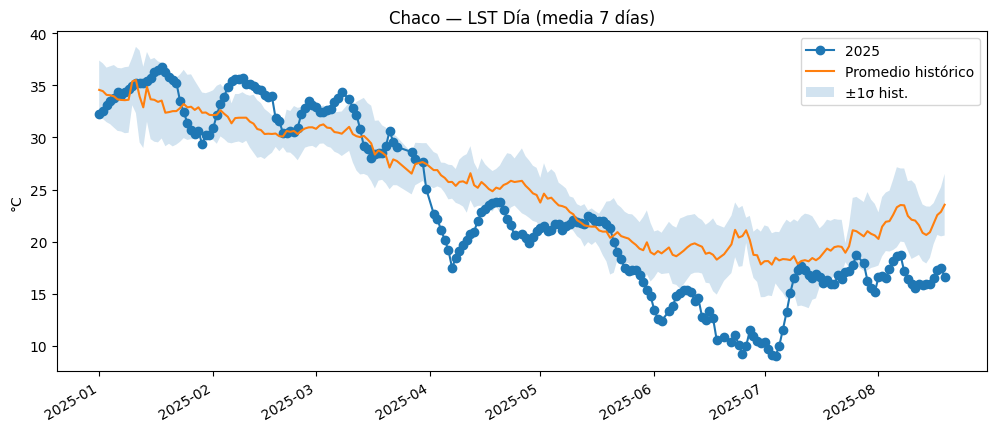

💾 Guardado: plots\lstd7_cordoba.png


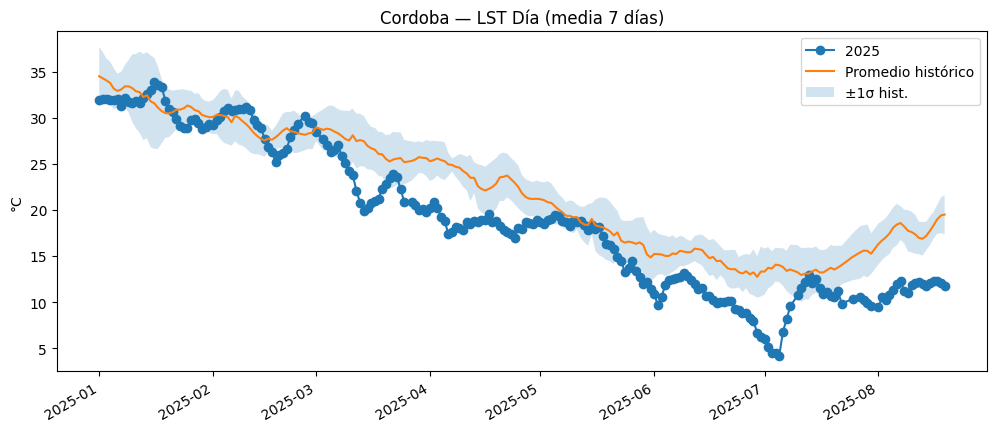

💾 Guardado: plots\lstd7_entre_rios.png


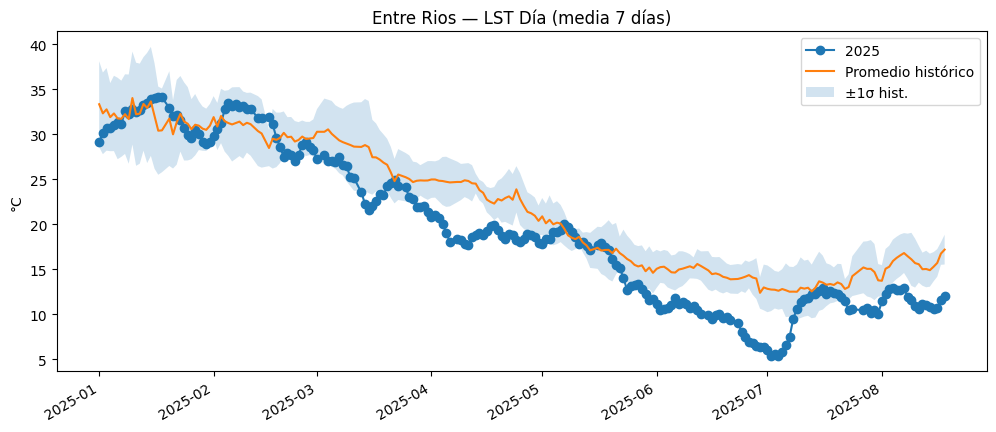

💾 Guardado: plots\lstd7_la_pampa.png


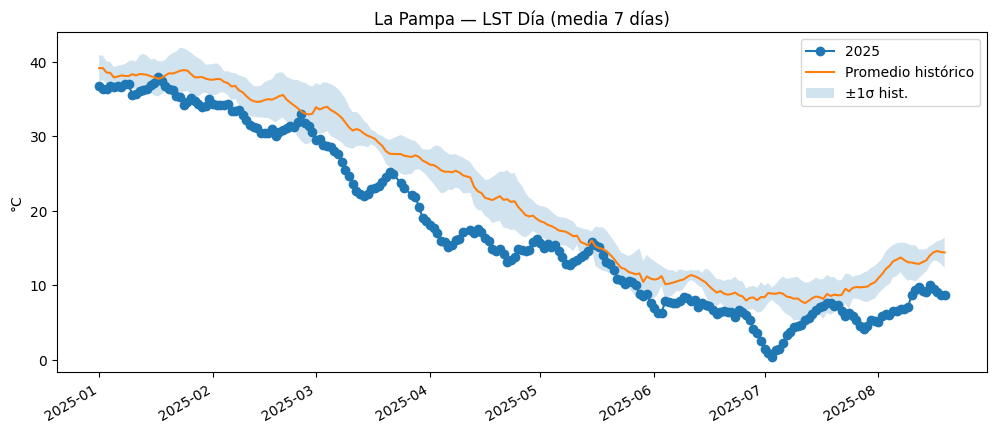

💾 Guardado: plots\lstd7_santa_fe.png


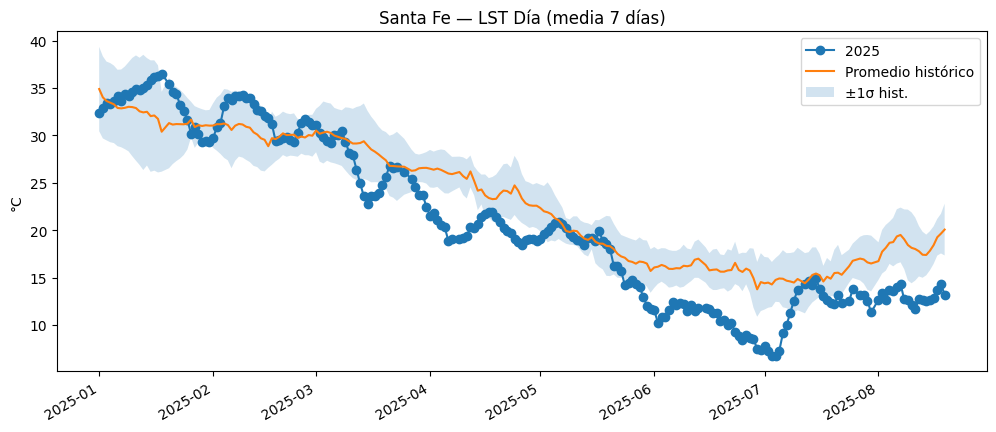

💾 Guardado: plots\lstn7_buenos_aires.png


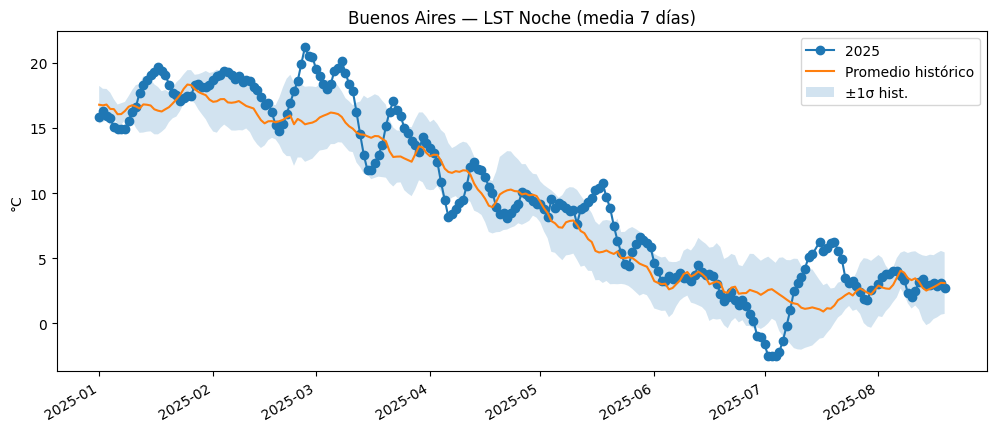

💾 Guardado: plots\lstn7_chaco.png


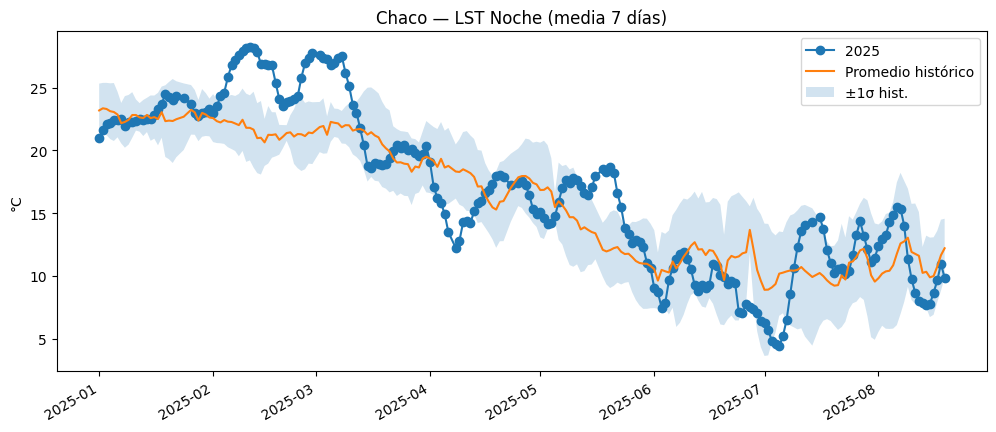

💾 Guardado: plots\lstn7_cordoba.png


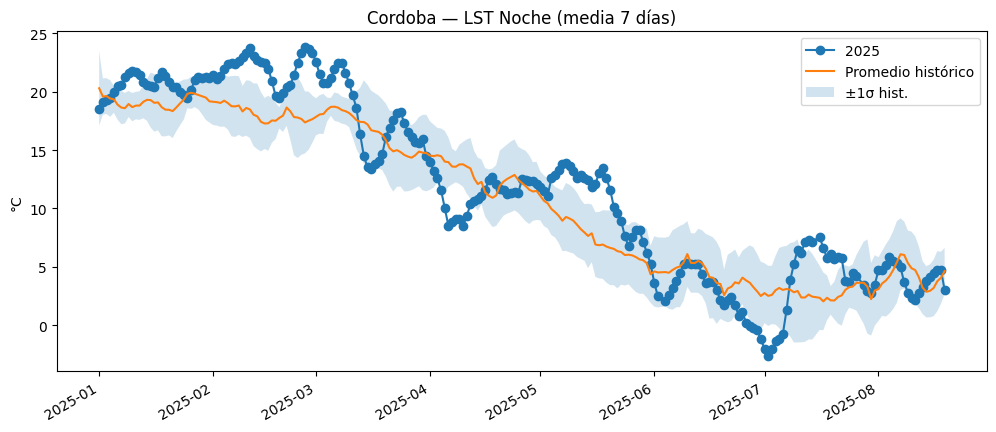

💾 Guardado: plots\lstn7_entre_rios.png


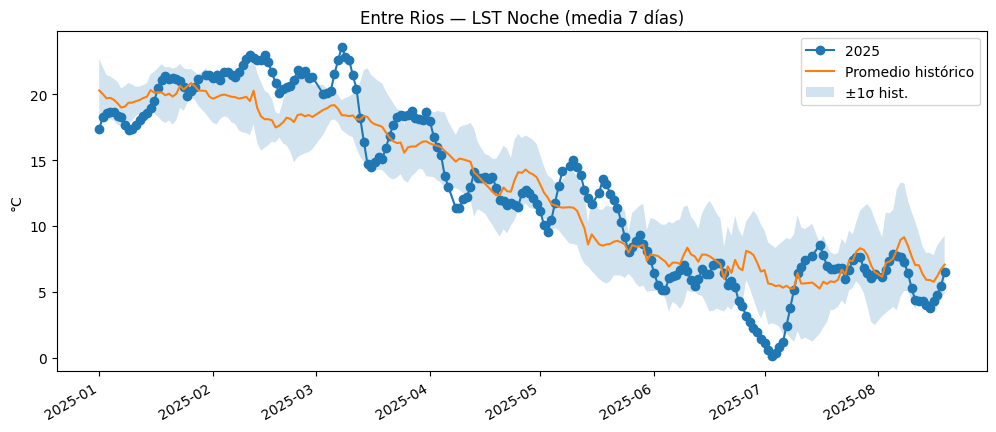

💾 Guardado: plots\lstn7_la_pampa.png


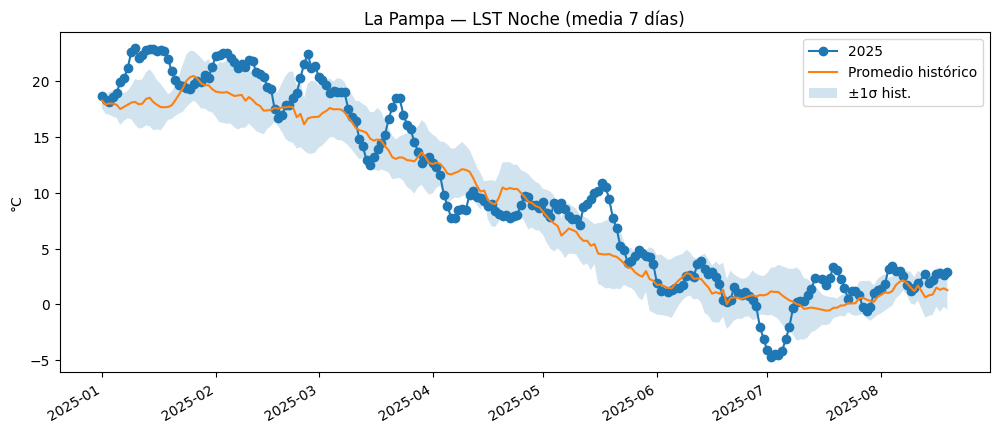

💾 Guardado: plots\lstn7_santa_fe.png


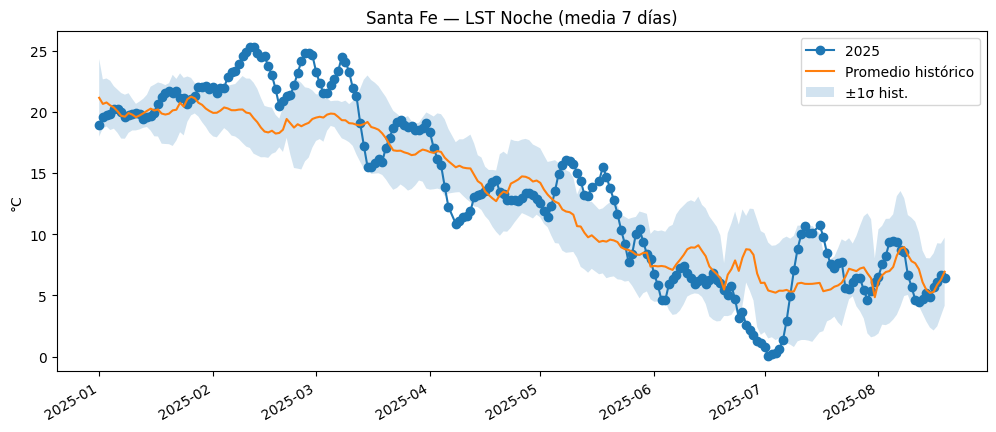

ℹ️ era5_rh_pct: sin histórico 2017–2024 suficiente, se salta la gráfica.
ℹ️ era5_vpd_kPa: sin histórico 2017–2024 suficiente, se salta la gráfica.
ℹ️ smap_sm: sin histórico 2017–2024 suficiente, se salta la gráfica.
ℹ️ era5_swvl1: sin histórico 2017–2024 suficiente, se salta la gráfica.
ℹ️ era5_evap_mm: sin histórico 2017–2024 suficiente, se salta la gráfica.
✅ Listo.


In [7]:
# ============================================
# Pipeline GEE + Climatología + Gráficos
# ============================================
import ee
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import unicodedata
from functools import reduce as _reduce
from pathlib import Path
import matplotlib.pyplot as plt
import os

# ================= CONFIG =================
PROVINCES = ["Buenos Aires", "Cordoba", "Santa Fe", "Chaco", "Entre Rios", "La Pampa"]

# Rangos: histórico para promedio y año actual (END exclusivo)
RANGE_HIST = ("2017-01-01", "2024-12-31")
RANGE_CURR = ("2025-01-01", (date.today() + timedelta(days=1)).strftime("%Y-%m-%d"))

# Activar datasets (además de los tradicionales)
DO_IMERG    = True   # precipitación IMERG 30-min -> diario
DO_ERA5     = True   # temp 2m y precip ERA5-Land diario
DO_LST      = True   # MODIS LST día/noche diario
DO_ET       = False  # MODIS ET 8 días (opcional)
DO_NDVI     = False  # MODIS NDVI 16 días (opcional)

# NUEVOS
DO_RH       = True   # humedad relativa (ERA5) y VPD
DO_SM_ERA5  = True   # humedad de suelo ERA5 swvl1 (0–7 cm)
DO_ERA5_ET  = True   # evaporación diaria ERA5 (mm/día)
DO_SMAP     = True   # humedad de suelo satelital SMAP (0–5 cm aprox.)
DO_SOIL_TEXTURE = True  # textura de suelos (estático, OpenLandMap)

# Escalas para promedios espaciales (m)
SCALE_IMERG = 11000
SCALE_ERA5  = 11000
SCALE_LST   = 1000
SCALE_ET    = 500
SCALE_NDVI  = 250
SCALE_SMAP  = 9000   # ~9 km

# Salidas (CSV)
CSV_HIST = "gee_alertas_hist_2017_2024.csv"
CSV_CURR = "gee_alertas_2025.csv"
CSV_ALL  = "gee_alertas_multi_2017_2025.csv"
CSV_SOIL_TEXTURE = "gee_suelos_textura.csv"

# Modo de actualización
INCREMENTAL_MODE = True     # True: solo nuevos datos; False: bajar todo de nuevo
BACKFILL_DAYS    = 7        # acolchado para revisiones/retrasos
DO_BACKFILL_FOR_NEW_VARS = False  # poner True si querés promedios históricos de las variables NUEVAS (tarda bastante)

# ================= INIT =================
ee.Initialize()

# ================= HELPERS =================
def _parse_date_mixed(s):
    """Parsea fechas mixtas (con/sin hora) a datetime64[ns]. Soporta pandas 1.x/2.x."""
    try:
        return pd.to_datetime(s, errors="coerce", format="mixed")
    except TypeError:
        return pd.to_datetime(s, errors="coerce", infer_datetime_format=True)

def _normalize_date_col(df):
    """Fuerza 'date' como string ISO YYYY-MM-DD (sin hora)."""
    df = df.copy()
    dts = _parse_date_mixed(df["date"])
    df["date"] = dts.dt.strftime("%Y-%m-%d")
    return df

def _norm(s: str) -> str:
    if s is None: return ""
    s = unicodedata.normalize('NFD', s)
    return ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn').lower().strip()

def provinces_fc(names):
    """FC GAUL(AR) con 'province' y geometría; match insensible a acentos."""
    gaul = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq("ADM0_NAME", "Argentina"))
    feats = gaul.getInfo()["features"]
    gaul_map = {_norm(f["properties"]["ADM1_NAME"]): f["properties"]["ADM1_NAME"] for f in feats}
    resolved = []
    for n in names:
        k = _norm(n)
        if k in gaul_map: resolved.append(gaul_map[k])
        else: print(f"⚠️ No encontré '{n}' en GAUL.")
    fc = gaul.filter(ee.Filter.inList("ADM1_NAME", resolved))
    fc = fc.map(lambda f: ee.Feature(ee.Feature(f).geometry(), {"province": ee.Feature(f).get("ADM1_NAME")}))
    try:
        print("✅ Provincias GAUL:", ee.FeatureCollection(fc).aggregate_array('province').getInfo())
    except: pass
    return fc

def dates_list(start_str, end_str):
    start = ee.Date(start_str); end = ee.Date(end_str)
    n = end.difference(start, "day").toInt()
    return ee.List.sequence(0, n.subtract(1)).map(lambda k: start.advance(ee.Number(k), "day"))

def month_range(y0, m0, y1, m1):
    cur = datetime(y0, m0, 1); end = datetime(y1, m1, 1); out = []
    while cur <= end:
        nxty = cur.year + (cur.month // 12); nxtm = (cur.month % 12) + 1
        nxt = datetime(nxty, nxtm, 1)
        out.append((cur.strftime('%Y-%m-%d'), nxt.strftime('%Y-%m-%d')))
        cur = nxt
    return out

def fc_to_df(fc, cols_keep):
    feats = ee.FeatureCollection(fc).getInfo()["features"]
    rows = []
    for f in feats:
        p = f.get("properties", {}) or {}
        rows.append({c: p.get(c) for c in cols_keep})
    return pd.DataFrame(rows, columns=cols_keep) if rows else pd.DataFrame(columns=cols_keep)

def reduce_ic_over_provinces(ic, prov_fc, scale, band_map, dataset_name):
    """reduceRegions mean sobre provincias por imagen; devuelve FC sin geometría."""
    in_bands  = list(band_map.keys())
    out_bands = list(band_map.values())
    keys_keep = ee.List(out_bands).cat(ee.List(['province', 'date', 'dataset']))
    def per_image(img):
        img = ee.Image(img).select(in_bands, out_bands)
        dstr = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")
        fc = img.reduceRegions(collection=prov_fc, reducer=ee.Reducer.mean(), scale=scale, tileScale=4) \
                .map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(ee.List(out_bands).cat(ee.List(['province']))))
                     .set({'date': dstr, 'dataset': dataset_name}))
        fc = fc.map(lambda f: ee.Feature(None, ee.Feature(f).toDictionary(keys_keep)))
        return fc
    return ee.FeatureCollection(ic.map(per_image).flatten())

# ================= DATASET BUILDERS (CHUNK MENSUAL) =================
PROV_FC = provinces_fc(PROVINCES)

# IMERG -> precip diaria (mm)
def build_imerg_df_month(ms, me):
    ic_30m = ee.ImageCollection("NASA/GPM_L3/IMERG_V07").filterDate(ms, me).select("precipitation")
    days = dates_list(ms, me)
    def daily_image(d):
        d = ee.Date(d)
        day_ic = ic_30m.filterDate(d, d.advance(1, "day"))
        daily = ee.Image(ee.Algorithms.If(day_ic.size().gt(0), day_ic.sum().multiply(0.5), ee.Image.constant(0))) \
                  .rename("imerg_precip_mm").set("system:time_start", d.millis())
        return daily
    daily_ic = ee.ImageCollection(days.map(daily_image))
    fc = reduce_ic_over_provinces(daily_ic, PROV_FC, SCALE_IMERG, {"imerg_precip_mm":"imerg_precip_mm"}, "IMERG")
    return fc_to_df(fc, ["province","date","imerg_precip_mm"])

# ERA5 -> T2m (°C), precip (mm), RH (%), VPD (kPa), SWVL1, ET diaria (mm)
def build_era5_df_month(ms, me):
    bands = ["temperature_2m", "dewpoint_temperature_2m", "total_precipitation_sum"]
    if DO_SM_ERA5:
        bands.append("volumetric_soil_water_layer_1")   # 0–7 cm (m3/m3)
    if DO_ERA5_ET:
        bands.append("total_evaporation_sum")           # m
    ic = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterDate(ms, me).select(bands)
    def conv(img):
        img = ee.Image(img)
        tC  = img.select("temperature_2m").subtract(273.15)
        tdC = img.select("dewpoint_temperature_2m").subtract(273.15)
        es = tC.multiply(17.67).divide(tC.add(243.5)).exp().multiply(6.112)
        e  = tdC.multiply(17.67).divide(tdC.add(243.5)).exp().multiply(6.112)
        rh = e.divide(es).multiply(100).clamp(0, 100).rename("era5_rh_pct")
        vpd = es.subtract(e).divide(10.0).rename("era5_vpd_kPa")  # hPa → kPa
        t2mC = tC.rename("era5_t2m_C")
        prmm = img.select("total_precipitation_sum").multiply(1000.0).rename("era5_precip_mm")
        out = t2mC.addBands([prmm, rh, vpd])
        if DO_SM_ERA5:
            out = out.addBands(img.select("volumetric_soil_water_layer_1").rename("era5_swvl1"))
        if DO_ERA5_ET:
            out = out.addBands(img.select("total_evaporation_sum").multiply(1000.0).rename("era5_evap_mm"))
        return out.copyProperties(img, ["system:time_start"])
    ic_conv = ic.map(conv)
    keep_all = ["era5_t2m_C","era5_precip_mm","era5_rh_pct","era5_vpd_kPa","era5_swvl1","era5_evap_mm"]
    try:
        bn = set(ee.Image(ic_conv.first()).bandNames().getInfo())
        keep = [k for k in keep_all if k in bn]
    except Exception:
        keep = keep_all
    fc = reduce_ic_over_provinces(ic_conv, PROV_FC, SCALE_ERA5, {k: k for k in keep}, "ERA5")
    return fc_to_df(fc, ["province","date"] + keep)

# MODIS LST diario -> °C
def build_lst_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD11A1").filterDate(ms, me).select(["LST_Day_1km","LST_Night_1km"])
    def toC(img):
        dayC   = ee.Image(img).select("LST_Day_1km").multiply(0.02).subtract(273.15).rename("lst_day_C")
        nightC = ee.Image(img).select("LST_Night_1km").multiply(0.02).subtract(273.15).rename("lst_night_C")
        return dayC.addBands(nightC).copyProperties(img, ["system:time_start"])
    ic = ic.map(toC)
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_LST,
                                  {"lst_day_C":"lst_day_C","lst_night_C":"lst_night_C"}, "MODIS_LST")
    return fc_to_df(fc, ["province","date","lst_day_C","lst_night_C"])

# MODIS ET 8-días (opcional)
def build_et_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD16A2").filterDate(ms, me).select(["ET"]) \
         .map(lambda img: ee.Image(img).multiply(0.1).rename("modis_et_mm_8d")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_ET, {"modis_et_mm_8d":"modis_et_mm_8d"}, "MODIS_ET")
    return fc_to_df(fc, ["province","date","modis_et_mm_8d"])

# MODIS NDVI 16-días (opcional)
def build_ndvi_df_month(ms, me):
    ic = ee.ImageCollection("MODIS/061/MOD13Q1").filterDate(ms, me).select(["NDVI"]) \
         .map(lambda img: ee.Image(img).multiply(0.0001).rename("modis_ndvi")
              .copyProperties(img, ["system:time_start"]))
    fc = reduce_ic_over_provinces(ic, PROV_FC, SCALE_NDVI, {"modis_ndvi":"modis_ndvi"}, "MODIS_NDVI")
    return fc_to_df(fc, ["province","date","modis_ndvi"])

# SMAP soil moisture (am/pm con QC)
def build_smap_df_month(ms, me):
    ic = (ee.ImageCollection("NASA/SMAP/SPL3SMP_E/006")
            .filterDate(ms, me)
            .select(["soil_moisture_am","soil_moisture_pm",
                     "retrieval_qual_flag_am","retrieval_qual_flag_pm"]))
    def combine(img):
        img = ee.Image(img)
        am  = img.select("soil_moisture_am")
        pm  = img.select("soil_moisture_pm")
        qam = img.select("retrieval_qual_flag_am").eq(0)
        qpm = img.select("retrieval_qual_flag_pm").eq(0)
        am  = am.updateMask(qam)
        pm  = pm.updateMask(qpm)
        count = am.mask().gt(0).rename("c1").add(pm.mask().gt(0).rename("c2"))
        sm = am.add(pm).divide(count.max(1)).rename("smap_sm")
        return sm.copyProperties(img, ["system:time_start"])
    ic2 = ic.map(combine)
    fc = reduce_ic_over_provinces(ic2, PROV_FC, SCALE_SMAP, {"smap_sm":"smap_sm"}, "SMAP")
    return fc_to_df(fc, ["province","date","smap_sm"])

# Textura de suelos (estático)
SOIL_TEXTURE_MAP = {1:"Cl",2:"SiCl",3:"SaCl",4:"ClLo",5:"SiClLo",6:"SaClLo",
                    7:"Lo",8:"SiLo",9:"SaLo",10:"Si",11:"LoSa",12:"Sa"}

def build_soil_texture_static():
    img = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02").select("b0")
    mode_fc = img.reduceRegions(PROV_FC, ee.Reducer.mode(), scale=250, tileScale=4)
    feats = mode_fc.getInfo()["features"]
    rows = []
    for f in feats:
        p = f.get("properties", {}) or {}
        val = int(p.get("mode")) if p.get("mode") is not None else None
        rows.append({
            "province": p.get("province"),
            "soil_texture_mode_code": val,
            "soil_texture_mode": SOIL_TEXTURE_MAP.get(val, None)
        })
    return pd.DataFrame(rows).sort_values("province")

# === Descarga chunk mensual y merge por ['province','date']
def fetch_range_chunked(start_str, end_str):
    y0, m0 = int(start_str[:4]), int(start_str[5:7])
    y1, m1 = int(end_str[:4]), int(end_str[5:7])
    months = month_range(y0, m0, y1, m1)

    dfs = []
    if DO_IMERG:
        parts = []
        for ms, me in months:
            print(f"IMERG {ms} → {me}")
            parts.append(build_imerg_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","imerg_precip_mm"]))

    if DO_ERA5 or DO_RH or DO_SM_ERA5 or DO_ERA5_ET:
        parts = []
        for ms, me in months:
            print(f"ERA5 {ms} → {me}")
            parts.append(build_era5_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True))

    if DO_LST:
        parts = []
        for ms, me in months:
            print(f"LST {ms} → {me}")
            parts.append(build_lst_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","lst_day_C","lst_night_C"]))

    if DO_ET:
        parts = []
        for ms, me in months:
            print(f"ET {ms} → {me}")
            parts.append(build_et_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_et_mm_8d"]))

    if DO_NDVI:
        parts = []
        for ms, me in months:
            print(f"NDVI {ms} → {me}")
            parts.append(build_ndvi_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","modis_ndvi"]))

    if DO_SMAP:
        parts = []
        for ms, me in months:
            print(f"SMAP {ms} → {me}")
            parts.append(build_smap_df_month(ms, me))
        dfs.append(pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["province","date","smap_sm"]))

    if not dfs:
        return pd.DataFrame(columns=["province","date"])

    df = _reduce(lambda l, r: pd.merge(l, r, on=["province","date"], how="outer"), dfs)
    df = df.sort_values(["province","date"]).reset_index(drop=True)

    # numéricos + precip preferida
    for c in ["imerg_precip_mm","era5_precip_mm","era5_t2m_C","lst_day_C","lst_night_C",
              "modis_et_mm_8d","modis_ndvi","era5_rh_pct","era5_vpd_kPa","era5_swvl1","era5_evap_mm","smap_sm"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

    if {"imerg_precip_mm","era5_precip_mm"}.issubset(df.columns):
        df["precip_mm_pref"] = df["imerg_precip_mm"].fillna(df["era5_precip_mm"])
    elif "era5_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["era5_precip_mm"]
    elif "imerg_precip_mm" in df.columns:
        df["precip_mm_pref"] = df["imerg_precip_mm"]

    return df

# ================= MODO INCREMENTAL =================
def incremental_update(csv_all_path=CSV_ALL, backfill_days=BACKFILL_DAYS):
    today_end = (date.today() + timedelta(days=1)).strftime("%Y-%m-%d")  # end exclusivo
    today_end_dt = pd.to_datetime(today_end)

    if Path(csv_all_path).exists() and INCREMENTAL_MODE:
        # 1) Cargar consolidado existente (como strings), normalizar y parsear seguro
        df_old = pd.read_csv(csv_all_path)
        if "date" not in df_old.columns or df_old.empty:
            last_dt = None
        else:
            df_old = _normalize_date_col(df_old)
            last_dt = pd.to_datetime(df_old["date"], errors="coerce").max()

        if (last_dt is None) or pd.isna(last_dt):
            print("ℹ️ CSV consolidado vacío. Descargando histórico + 2025…")
            df_hist = fetch_range_chunked(*RANGE_HIST)
            df_curr = fetch_range_chunked(RANGE_CURR[0], today_end)
            df_new = pd.concat([df_hist, df_curr], ignore_index=True)
        else:
            # Clamp por si last_dt quedó en el futuro
            if last_dt >= today_end_dt:
                last_dt = today_end_dt - pd.Timedelta(days=1)
            # 2) Rango incremental: (last_dt - backfill) → today_end
            inc_start_dt = max(pd.to_datetime(RANGE_CURR[0]), last_dt - pd.Timedelta(days=backfill_days))
            if inc_start_dt >= today_end_dt:
                inc_start_dt = today_end_dt - pd.Timedelta(days=backfill_days+1)
            inc_start = inc_start_dt.strftime("%Y-%m-%d")
            print(f"🔄 Modo incremental: {inc_start} → {today_end} (backfill {backfill_days} días)")
            df_new = fetch_range_chunked(inc_start, today_end)

        # 3) Unir y deduplicar
        df_all_multi = pd.concat([df_old, df_new], ignore_index=True)
        df_all_multi = (df_all_multi
                        .drop_duplicates(["province","date"], keep="last")
                        .sort_values(["province","date"])
                        .reset_index(drop=True))
        df_all_multi = _normalize_date_col(df_all_multi)
        df_all_multi.to_csv(csv_all_path, index=False)
        print("✅ Actualizado:", csv_all_path, "| Filas:", len(df_all_multi))
        return df_all_multi

    else:
        # Primer corrido o full rebuild
        if INCREMENTAL_MODE:
            print("📥 Primer corrido (no existe CSV). Descargando histórico + 2025…")
        else:
            print("♻️ FULL REBUILD: re-descargando histórico + 2025…")
        df_hist = fetch_range_chunked(*RANGE_HIST)
        df_curr = fetch_range_chunked(RANGE_CURR[0], today_end)
        df_all_multi = pd.concat([df_hist, df_curr], ignore_index=True)
        df_all_multi = (df_all_multi
                        .drop_duplicates(["province","date"], keep="last")
                        .sort_values(["province","date"])
                        .reset_index(drop=True))
        df_all_multi = _normalize_date_col(df_all_multi)
        df_all_multi.to_csv(csv_all_path, index=False)
        print("✅ Guardado inicial:", csv_all_path, "| Filas:", len(df_all_multi))
        return df_all_multi

# === Ejecutar actualización (incremental o full) ===
df_all_multi = incremental_update()

# === Backfill histórico para variables NUEVAS (opcional) ===
NEW_VARS = ["era5_rh_pct","era5_vpd_kPa","era5_swvl1","era5_evap_mm","smap_sm"]

def needs_backfill(df, vars_list, hist_range):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"])
    mask_hist = (d["date"] >= pd.to_datetime(hist_range[0])) & (d["date"] <= pd.to_datetime(hist_range[1]))
    d = d.loc[mask_hist]
    to_fetch = []
    for v in vars_list:
        if v not in d.columns:
            to_fetch.append(v); continue
        nn = d[v].notna().mean() if len(d) else 0.0
        if nn < 0.8:
            to_fetch.append(v)
    return to_fetch

if DO_BACKFILL_FOR_NEW_VARS:
    to_fetch = needs_backfill(df_all_multi, NEW_VARS, RANGE_HIST)
    if to_fetch:
        print("🔁 Backfill histórico requerido para:", to_fetch)
        _DO_ERA5, _DO_RH, _DO_SM_ERA5, _DO_ERA5_ET, _DO_SMAP = DO_ERA5, DO_RH, DO_SM_ERA5, DO_ERA5_ET, DO_SMAP
        try:
            DO_ERA5  = True
            if "era5_rh_pct" in to_fetch or "era5_vpd_kPa" in to_fetch: DO_RH = True
            if "era5_swvl1" in to_fetch: DO_SM_ERA5 = True
            if "era5_evap_mm" in to_fetch: DO_ERA5_ET = True
            if "smap_sm" in to_fetch: DO_SMAP = True

            df_hist_backfill = fetch_range_chunked(*RANGE_HIST)

            key = ["province","date"]
            df_merge = pd.merge(df_all_multi, df_hist_backfill, on=key, how="outer", suffixes=("", "_bf"))
            for v in NEW_VARS:
                if v + "_bf" in df_merge.columns:
                    df_merge[v] = df_merge[v].combine_first(df_merge[v + "_bf"])
                    df_merge.drop(columns=[v + "_bf"], inplace=True)
            df_merge = df_merge.sort_values(key).drop_duplicates(key, keep="last").reset_index(drop=True)
            df_merge = _normalize_date_col(df_merge)
            df_merge.to_csv(CSV_ALL, index=False)
            df_all_multi = df_merge
            print("✅ Backfill histórico aplicado y guardado:", CSV_ALL)
        finally:
            DO_ERA5, DO_RH, DO_SM_ERA5, DO_ERA5_ET, DO_SMAP = _DO_ERA5, _DO_RH, _DO_SM_ERA5, _DO_ERA5_ET, _DO_SMAP
    else:
        print("👍 Histórico completo para variables nuevas (no se requiere backfill).")
else:
    # Guardar el consolidado actual ya normalizado
    df_all_multi = _normalize_date_col(df_all_multi)
    df_all_multi.to_csv(CSV_ALL, index=False)

# (Opcional) Guardar capa estática de suelos una vez
if DO_SOIL_TEXTURE:
    if not Path(CSV_SOIL_TEXTURE).exists():
        df_soil = build_soil_texture_static()
        df_soil.to_csv(CSV_SOIL_TEXTURE, index=False, encoding="utf-8")
        print("🗺️ Suelos (textura) guardado:", CSV_SOIL_TEXTURE)
    else:
        print("🗺️ Suelos (textura) ya existe:", CSV_SOIL_TEXTURE)

# ================= GRÁFICOS: provincia vs promedio histórico =================

# --- Cargar datos para gráficos (usa df_all_multi en memoria)
try:
    df_plot = df_all_multi.copy()
except NameError:
    df_plot = pd.read_csv(CSV_ALL)
df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce")

HIST_START = "2017-01-01"
HIST_END   = "2024-12-31"
TARGET_YEAR = 2025

# Variables a graficar
VARS = [
    {"var":"precip_mm_pref", "label":"Precipitación (acum. 7 días)", "unit":"mm",   "mode":"sum",  "window":7, "slug":"precip7"},
    {"var":"era5_t2m_C",     "label":"ERA5 T2m (media 7 días)",      "unit":"°C",   "mode":"mean", "window":7, "slug":"t2m7"},
    {"var":"lst_day_C",      "label":"LST Día (media 7 días)",       "unit":"°C",   "mode":"mean", "window":7, "slug":"lstd7"},
    {"var":"lst_night_C",    "label":"LST Noche (media 7 días)",     "unit":"°C",   "mode":"mean", "window":7, "slug":"lstn7"},
    {"var":"era5_rh_pct",    "label":"Humedad Relativa (media 7 días)", "unit":"%",    "mode":"mean", "window":7, "slug":"rh7"},
    {"var":"era5_vpd_kPa",   "label":"VPD (media 7 días)",              "unit":"kPa",  "mode":"mean", "window":7, "slug":"vpd7"},
    {"var":"smap_sm",        "label":"SMAP humedad suelo (media 7 días)", "unit":"m³/m³","mode":"mean","window":7, "slug":"smap7"},
    {"var":"era5_swvl1",     "label":"ERA5 humedad suelo 0–7 cm (media 7 días)", "unit":"m³/m³","mode":"mean","window":7,"slug":"swvl1_7"},
    {"var":"era5_evap_mm",   "label":"ERA5 Evaporación (acum. 7 días)", "unit":"mm",   "mode":"sum",  "window":7, "slug":"evap7"},
    # {"var":"modis_et_mm_8d","label":"MODIS ET (mm/8d) (sin suavizar)", "unit":"mm/8d","mode":"raw","window":1,"slug":"et8d"},
    # {"var":"modis_ndvi",    "label":"NDVI (sin suavizar)",             "unit":"",     "mode":"raw","window":1,"slug":"ndvi"},
]

# Forzar numéricas
num_cols = [
    "imerg_precip_mm","era5_precip_mm","precip_mm_pref","era5_t2m_C",
    "lst_day_C","lst_night_C","modis_et_mm_8d","modis_ndvi",
    "era5_rh_pct","era5_vpd_kPa","era5_swvl1","era5_evap_mm","smap_sm"
]
for c in num_cols:
    if c in df_plot.columns:
        df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

df_plot = df_plot.sort_values(["province","date"])

def compute_rolled(df_in, var, mode="mean", window=7):
    """Devuelve serie suavizada por provincia con 'value' float, y columnas year/mmdd."""
    if var not in df_in.columns:
        return pd.DataFrame(columns=["province","date","year","mmdd","value"])
    d = df_in[["province","date",var]].copy()
    d[var] = pd.to_numeric(d[var], errors="coerce")
    d = d.dropna(subset=[var])
    if d.empty:
        return pd.DataFrame(columns=["province","date","year","mmdd","value"])
    d = d.sort_values(["province","date"])
    if mode == "sum":
        d["value"] = d.groupby("province", as_index=False)[var].transform(lambda s: s.rolling(window, min_periods=1).sum())
    elif mode == "mean":
        d["value"] = d.groupby("province", as_index=False)[var].transform(lambda s: s.rolling(window, min_periods=1).mean())
    else:  # raw
        d["value"] = d[var]
    d["value"] = pd.to_numeric(d["value"], errors="coerce").astype(float)
    d["year"] = d["date"].dt.year
    d["mmdd"] = d["date"].dt.strftime("%m-%d")
    d = d[d["mmdd"] != "02-29"]
    return d[["province","date","year","mmdd","value"]]

def climatology_from_rolled(d, hist_start=HIST_START, hist_end=HIST_END):
    """Promedio y std por provincia y día-mes, usando la serie ya suavizada (value float)."""
    if d.empty:
        return pd.DataFrame(columns=["province","mmdd","mean","std","count"])
    mask = (d["date"] >= pd.to_datetime(hist_start)) & (d["date"] <= pd.to_datetime(hist_end))
    dh = d.loc[mask].copy()
    if dh.empty:
        return pd.DataFrame(columns=["province","mmdd","mean","std","count"])
    dh["value"] = pd.to_numeric(dh["value"], errors="coerce").astype(float)
    clim = (dh.groupby(["province","mmdd"], dropna=False)["value"]
              .agg(mean="mean", std="std", count="count")
              .reset_index())
    return clim

def anomalies_vs_clim(d, clim, target_year=TARGET_YEAR):
    """Une el año objetivo con la climatología y calcula anomalías."""
    if d.empty or clim.empty:
        return pd.DataFrame(columns=["province","date","mmdd","value","mean","std","anom","anom_pct","zscore"])
    cur = d[d["year"] == target_year].copy()
    if cur.empty:
        return pd.DataFrame(columns=["province","date","mmdd","value","mean","std","anom","anom_pct","zscore"])
    m = cur.merge(clim, on=["province","mmdd"], how="left")
    m["anom"] = m["value"] - m["mean"]
    m["anom_pct"] = np.where(m["mean"].abs() > 1e-9, 100.0 * m["anom"] / m["mean"], np.nan)
    m["zscore"] = (m["anom"] / m["std"]).replace([np.inf, -np.inf], np.nan)
    return m.sort_values(["province","date"])

def plot_var_vs_clim(m, province, title, ylabel, save_dir="plots", filename=None):
    """Grafica 2025 vs promedio histórico con banda ±1σ y guarda PNG."""
    d = m[m["province"] == province].sort_values("date")
    if d.empty or d["mean"].isna().all():
        print(f"ℹ️ Sin climatología para {province} en {title} (¿hiciste backfill de esa variable?).")
        return
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(d["date"], d["value"], marker="o", label=str(TARGET_YEAR))
    ax.plot(d["date"], d["mean"], label="Promedio histórico")
    if d["std"].notna().any():
        ax.fill_between(d["date"], d["mean"] - d["std"], d["mean"] + d["std"], alpha=0.2, label="±1σ hist.")
    ax.set_title(f"{province} — {title}")
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.autofmt_xdate()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fname = filename or (title.replace(" ", "_").lower() + f"_{province}.png")
        out = os.path.join(save_dir, fname.replace(" ", "_").lower())
        plt.savefig(out, bbox_inches="tight", dpi=140)
        print("💾 Guardado:", out)
    plt.show()

# --- Driver: recorre variables y provincias
provinces = sorted(df_plot["province"].dropna().unique())
for cfg in VARS:
    var = cfg["var"]
    if var not in df_plot.columns:
        print(f"ℹ️ Omito {var}: no está en el DataFrame.")
        continue

    drolled = compute_rolled(df_plot, var, mode=cfg["mode"], window=cfg["window"])
    clim = climatology_from_rolled(drolled, HIST_START, HIST_END)
    if clim.empty:
        print(f"ℹ️ {var}: sin histórico 2017–2024 suficiente, se salta la gráfica.")
        continue

    m = anomalies_vs_clim(drolled, clim, TARGET_YEAR)
    if m.empty:
        print(f"ℹ️ {var}: sin datos {TARGET_YEAR} o sin match con climatología.")
        continue

    for prov in provinces:
        plot_var_vs_clim(
            m, prov,
            title=cfg["label"],
            ylabel=cfg["unit"],
            save_dir="plots",
            filename=f"{cfg['slug']}_{prov}.png"
        )

print("✅ Listo.")
